In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b25_roi_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 672)
(884582, 3)
validation
(154411, 672)
(154411, 3)
test
(115112, 672)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 672)]             0         


 dense (Dense)               (None, 2048)              1378304   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 4165891 (15.89 MB)


Trainable params: 4165891 (15.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:19 - loss: 1.2682 - STD: 0.2012 - MAE: 0.4153

2/9 [=====>........................] - ETA: 2s - loss: 1.1822 - STD: 0.1699 - MAE: 0.4196  

3/9 [=========>....................] - ETA: 2s - loss: 1.1513 - STD: 0.1231 - MAE: 0.4269

4/9 [============>.................] - ETA: 1s - loss: 1.1457 - STD: 0.1022 - MAE: 0.4326

5/9 [===============>..............] - ETA: 1s - loss: 1.1405 - STD: 0.0872 - MAE: 0.4358

6/9 [===================>..........] - ETA: 1s - loss: 1.1324 - STD: 0.0745 - MAE: 0.4370

7/9 [======================>.......] - ETA: 0s - loss: 1.1242 - STD: 0.0716 - MAE: 0.4369

8/9 [=========================>....] - ETA: 1s - loss: 1.1191 - STD: 0.0741 - MAE: 0.4362

9/9 [==============================] - ETA: 0s - loss: 1.1152 - STD: 0.0788 - MAE: 0.4352

9/9 [==============================] - 23s 2s/step - loss: 1.1152 - STD: 0.0788 - MAE: 0.4352 - val_loss: 1.0899 - val_STD: 0.1276 - val_MAE: 0.4257


Epoch 2/10000


1/9 [==>...........................] - ETA: 3s - loss: 1.0892 - STD: 0.1276 - MAE: 0.4254

2/9 [=====>........................] - ETA: 2s - loss: 1.0911 - STD: 0.1276 - MAE: 0.4257

3/9 [=========>....................] - ETA: 2s - loss: 1.0897 - STD: 0.1252 - MAE: 0.4259

4/9 [============>.................] - ETA: 1s - loss: 1.0880 - STD: 0.1213 - MAE: 0.4266

5/9 [===============>..............] - ETA: 1s - loss: 1.0856 - STD: 0.1161 - MAE: 0.4273

6/9 [===================>..........] - ETA: 1s - loss: 1.0836 - STD: 0.1099 - MAE: 0.4282

7/9 [======================>.......] - ETA: 0s - loss: 1.0823 - STD: 0.1034 - MAE: 0.4292

8/9 [=========================>....] - ETA: 0s - loss: 1.0818 - STD: 0.0968 - MAE: 0.4302

9/9 [==============================] - ETA: 0s - loss: 1.0815 - STD: 0.0906 - MAE: 0.4312

9/9 [==============================] - 4s 407ms/step - loss: 1.0815 - STD: 0.0906 - MAE: 0.4312 - val_loss: 1.0800 - val_STD: 0.0356 - val_MAE: 0.4391


Epoch 3/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0800 - STD: 0.0356 - MAE: 0.4391

2/9 [=====>........................] - ETA: 2s - loss: 1.0793 - STD: 0.0364 - MAE: 0.4389

3/9 [=========>....................] - ETA: 2s - loss: 1.0784 - STD: 0.0394 - MAE: 0.4385

4/9 [============>.................] - ETA: 1s - loss: 1.0772 - STD: 0.0436 - MAE: 0.4378

5/9 [===============>..............] - ETA: 1s - loss: 1.0762 - STD: 0.0486 - MAE: 0.4370

6/9 [===================>..........] - ETA: 1s - loss: 1.0754 - STD: 0.0540 - MAE: 0.4362

7/9 [======================>.......] - ETA: 0s - loss: 1.0750 - STD: 0.0592 - MAE: 0.4354

8/9 [=========================>....] - ETA: 0s - loss: 1.0747 - STD: 0.0637 - MAE: 0.4346

9/9 [==============================] - ETA: 0s - loss: 1.0744 - STD: 0.0674 - MAE: 0.4340

9/9 [==============================] - 4s 421ms/step - loss: 1.0744 - STD: 0.0674 - MAE: 0.4340 - val_loss: 1.0701 - val_STD: 0.0946 - val_MAE: 0.4291


Epoch 4/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0708 - STD: 0.0948 - MAE: 0.4291

2/9 [=====>........................] - ETA: 2s - loss: 1.0699 - STD: 0.0927 - MAE: 0.4292

3/9 [=========>....................] - ETA: 1s - loss: 1.0680 - STD: 0.0903 - MAE: 0.4293

4/9 [============>.................] - ETA: 1s - loss: 1.0660 - STD: 0.0876 - MAE: 0.4293

5/9 [===============>..............] - ETA: 1s - loss: 1.0639 - STD: 0.0849 - MAE: 0.4292

6/9 [===================>..........] - ETA: 1s - loss: 1.0617 - STD: 0.0821 - MAE: 0.4292

7/9 [======================>.......] - ETA: 0s - loss: 1.0592 - STD: 0.0794 - MAE: 0.4290

8/9 [=========================>....] - ETA: 0s - loss: 1.0560 - STD: 0.0773 - MAE: 0.4285

9/9 [==============================] - ETA: 0s - loss: 1.0523 - STD: 0.0763 - MAE: 0.4278

9/9 [==============================] - 4s 423ms/step - loss: 1.0523 - STD: 0.0763 - MAE: 0.4278 - val_loss: 1.0084 - val_STD: 0.0719 - val_MAE: 0.4175


Epoch 5/10000


1/9 [==>...........................] - ETA: 4s - loss: 1.0051 - STD: 0.0732 - MAE: 0.4165

2/9 [=====>........................] - ETA: 2s - loss: 0.9965 - STD: 0.0783 - MAE: 0.4132

3/9 [=========>....................] - ETA: 1s - loss: 0.9850 - STD: 0.0855 - MAE: 0.4092

4/9 [============>.................] - ETA: 1s - loss: 0.9731 - STD: 0.0929 - MAE: 0.4047

5/9 [===============>..............] - ETA: 1s - loss: 0.9604 - STD: 0.1019 - MAE: 0.3995

6/9 [===================>..........] - ETA: 1s - loss: 0.9481 - STD: 0.1109 - MAE: 0.3942

7/9 [======================>.......] - ETA: 0s - loss: 0.9360 - STD: 0.1214 - MAE: 0.3884

8/9 [=========================>....] - ETA: 0s - loss: 0.9244 - STD: 0.1308 - MAE: 0.3829

9/9 [==============================] - ETA: 0s - loss: 0.9135 - STD: 0.1408 - MAE: 0.3772

9/9 [==============================] - 4s 408ms/step - loss: 0.9135 - STD: 0.1408 - MAE: 0.3772 - val_loss: 0.8379 - val_STD: 0.2278 - val_MAE: 0.3324


Epoch 6/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8051 - STD: 0.2278 - MAE: 0.3244

2/9 [=====>........................] - ETA: 2s - loss: 0.7978 - STD: 0.2326 - MAE: 0.3211

3/9 [=========>....................] - ETA: 2s - loss: 0.7966 - STD: 0.2396 - MAE: 0.3174

4/9 [============>.................] - ETA: 1s - loss: 0.7925 - STD: 0.2408 - MAE: 0.3163

5/9 [===============>..............] - ETA: 1s - loss: 0.7876 - STD: 0.2433 - MAE: 0.3142

6/9 [===================>..........] - ETA: 1s - loss: 0.7831 - STD: 0.2447 - MAE: 0.3125

7/9 [======================>.......] - ETA: 0s - loss: 0.7795 - STD: 0.2447 - MAE: 0.3119

8/9 [=========================>....] - ETA: 0s - loss: 0.7758 - STD: 0.2470 - MAE: 0.3100

9/9 [==============================] - ETA: 0s - loss: 0.7710 - STD: 0.2477 - MAE: 0.3088

9/9 [==============================] - 4s 422ms/step - loss: 0.7710 - STD: 0.2477 - MAE: 0.3088 - val_loss: 0.7695 - val_STD: 0.2545 - val_MAE: 0.3063


Epoch 7/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.7269 - STD: 0.2578 - MAE: 0.2961

2/9 [=====>........................] - ETA: 2s - loss: 0.7261 - STD: 0.2673 - MAE: 0.2909

3/9 [=========>....................] - ETA: 2s - loss: 0.7245 - STD: 0.2662 - MAE: 0.2914

4/9 [============>.................] - ETA: 1s - loss: 0.7201 - STD: 0.2685 - MAE: 0.2894

5/9 [===============>..............] - ETA: 1s - loss: 0.7169 - STD: 0.2699 - MAE: 0.2881

6/9 [===================>..........] - ETA: 1s - loss: 0.7155 - STD: 0.2692 - MAE: 0.2883

7/9 [======================>.......] - ETA: 0s - loss: 0.7142 - STD: 0.2707 - MAE: 0.2873

8/9 [=========================>....] - ETA: 0s - loss: 0.7123 - STD: 0.2700 - MAE: 0.2873

9/9 [==============================] - ETA: 0s - loss: 0.7101 - STD: 0.2706 - MAE: 0.2866

9/9 [==============================] - 4s 408ms/step - loss: 0.7101 - STD: 0.2706 - MAE: 0.2866 - val_loss: 0.7069 - val_STD: 0.2785 - val_MAE: 0.2826


Epoch 8/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6880 - STD: 0.2790 - MAE: 0.2782

2/9 [=====>........................] - ETA: 2s - loss: 0.6888 - STD: 0.2765 - MAE: 0.2799

3/9 [=========>....................] - ETA: 2s - loss: 0.6898 - STD: 0.2820 - MAE: 0.2769

4/9 [============>.................] - ETA: 1s - loss: 0.6881 - STD: 0.2812 - MAE: 0.2770

5/9 [===============>..............] - ETA: 1s - loss: 0.6849 - STD: 0.2829 - MAE: 0.2754

6/9 [===================>..........] - ETA: 1s - loss: 0.6821 - STD: 0.2841 - MAE: 0.2742

7/9 [======================>.......] - ETA: 0s - loss: 0.6808 - STD: 0.2839 - MAE: 0.2741

8/9 [=========================>....] - ETA: 0s - loss: 0.6794 - STD: 0.2854 - MAE: 0.2729

9/9 [==============================] - ETA: 0s - loss: 0.6771 - STD: 0.2856 - MAE: 0.2725

9/9 [==============================] - 4s 407ms/step - loss: 0.6771 - STD: 0.2856 - MAE: 0.2725 - val_loss: 0.6834 - val_STD: 0.2922 - val_MAE: 0.2704


Epoch 9/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6572 - STD: 0.2918 - MAE: 0.2653

2/9 [=====>........................] - ETA: 2s - loss: 0.6566 - STD: 0.2946 - MAE: 0.2635

3/9 [=========>....................] - ETA: 2s - loss: 0.6571 - STD: 0.2927 - MAE: 0.2648

4/9 [============>.................] - ETA: 1s - loss: 0.6565 - STD: 0.2938 - MAE: 0.2640

5/9 [===============>..............] - ETA: 1s - loss: 0.6541 - STD: 0.2934 - MAE: 0.2637

6/9 [===================>..........] - ETA: 1s - loss: 0.6524 - STD: 0.2937 - MAE: 0.2632

7/9 [======================>.......] - ETA: 0s - loss: 0.6500 - STD: 0.2945 - MAE: 0.2623

8/9 [=========================>....] - ETA: 0s - loss: 0.6490 - STD: 0.2949 - MAE: 0.2619

9/9 [==============================] - ETA: 0s - loss: 0.6482 - STD: 0.2959 - MAE: 0.2611

9/9 [==============================] - 4s 412ms/step - loss: 0.6482 - STD: 0.2959 - MAE: 0.2611 - val_loss: 0.6732 - val_STD: 0.2989 - val_MAE: 0.2652


Epoch 10/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6404 - STD: 0.2968 - MAE: 0.2594

2/9 [=====>........................] - ETA: 2s - loss: 0.6362 - STD: 0.2999 - MAE: 0.2564

3/9 [=========>....................] - ETA: 2s - loss: 0.6351 - STD: 0.2993 - MAE: 0.2566

4/9 [============>.................] - ETA: 1s - loss: 0.6334 - STD: 0.3013 - MAE: 0.2549

5/9 [===============>..............] - ETA: 1s - loss: 0.6328 - STD: 0.3016 - MAE: 0.2548

6/9 [===================>..........] - ETA: 1s - loss: 0.6324 - STD: 0.3034 - MAE: 0.2535

7/9 [======================>.......] - ETA: 0s - loss: 0.6321 - STD: 0.3033 - MAE: 0.2536

8/9 [=========================>....] - ETA: 0s - loss: 0.6316 - STD: 0.3044 - MAE: 0.2527

9/9 [==============================] - ETA: 0s - loss: 0.6305 - STD: 0.3043 - MAE: 0.2526

9/9 [==============================] - 4s 409ms/step - loss: 0.6305 - STD: 0.3043 - MAE: 0.2526 - val_loss: 0.6160 - val_STD: 0.3090 - val_MAE: 0.2475


Epoch 11/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6121 - STD: 0.3102 - MAE: 0.2446

2/9 [=====>........................] - ETA: 2s - loss: 0.6097 - STD: 0.3101 - MAE: 0.2446

3/9 [=========>....................] - ETA: 2s - loss: 0.6067 - STD: 0.3108 - MAE: 0.2438

4/9 [============>.................] - ETA: 1s - loss: 0.6060 - STD: 0.3114 - MAE: 0.2432

5/9 [===============>..............] - ETA: 1s - loss: 0.6075 - STD: 0.3109 - MAE: 0.2440

6/9 [===================>..........] - ETA: 1s - loss: 0.6119 - STD: 0.3115 - MAE: 0.2442

7/9 [======================>.......] - ETA: 0s - loss: 0.6168 - STD: 0.3111 - MAE: 0.2457

8/9 [=========================>....] - ETA: 0s - loss: 0.6190 - STD: 0.3119 - MAE: 0.2455

9/9 [==============================] - ETA: 0s - loss: 0.6163 - STD: 0.3122 - MAE: 0.2447

9/9 [==============================] - 4s 402ms/step - loss: 0.6163 - STD: 0.3122 - MAE: 0.2447 - val_loss: 0.6740 - val_STD: 0.3179 - val_MAE: 0.2544


Epoch 12/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6115 - STD: 0.3142 - MAE: 0.2438

2/9 [=====>........................] - ETA: 2s - loss: 0.6183 - STD: 0.3178 - MAE: 0.2414

3/9 [=========>....................] - ETA: 2s - loss: 0.6067 - STD: 0.3174 - MAE: 0.2394

4/9 [============>.................] - ETA: 1s - loss: 0.6064 - STD: 0.3173 - MAE: 0.2397

5/9 [===============>..............] - ETA: 1s - loss: 0.6084 - STD: 0.3183 - MAE: 0.2391

6/9 [===================>..........] - ETA: 1s - loss: 0.6035 - STD: 0.3186 - MAE: 0.2380

7/9 [======================>.......] - ETA: 0s - loss: 0.6051 - STD: 0.3184 - MAE: 0.2387

8/9 [=========================>....] - ETA: 0s - loss: 0.6047 - STD: 0.3187 - MAE: 0.2382

9/9 [==============================] - ETA: 0s - loss: 0.6014 - STD: 0.3188 - MAE: 0.2375

9/9 [==============================] - 4s 416ms/step - loss: 0.6014 - STD: 0.3188 - MAE: 0.2375 - val_loss: 0.6852 - val_STD: 0.3242 - val_MAE: 0.2526


Epoch 13/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.6093 - STD: 0.3192 - MAE: 0.2404

2/9 [=====>........................] - ETA: 2s - loss: 0.5945 - STD: 0.3206 - MAE: 0.2353

3/9 [=========>....................] - ETA: 2s - loss: 0.5900 - STD: 0.3216 - MAE: 0.2334

4/9 [============>.................] - ETA: 1s - loss: 0.5915 - STD: 0.3218 - MAE: 0.2340

5/9 [===============>..............] - ETA: 1s - loss: 0.5873 - STD: 0.3219 - MAE: 0.2328

6/9 [===================>..........] - ETA: 1s - loss: 0.5866 - STD: 0.3220 - MAE: 0.2325

7/9 [======================>.......] - ETA: 0s - loss: 0.5850 - STD: 0.3221 - MAE: 0.2322

8/9 [=========================>....] - ETA: 0s - loss: 0.5821 - STD: 0.3224 - MAE: 0.2314

9/9 [==============================] - ETA: 0s - loss: 0.5817 - STD: 0.3228 - MAE: 0.2310

9/9 [==============================] - 4s 424ms/step - loss: 0.5817 - STD: 0.3228 - MAE: 0.2310 - val_loss: 0.5968 - val_STD: 0.3280 - val_MAE: 0.2327


Epoch 14/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5662 - STD: 0.3268 - MAE: 0.2257

2/9 [=====>........................] - ETA: 2s - loss: 0.5666 - STD: 0.3273 - MAE: 0.2254

3/9 [=========>....................] - ETA: 2s - loss: 0.5688 - STD: 0.3270 - MAE: 0.2256

4/9 [============>.................] - ETA: 1s - loss: 0.5667 - STD: 0.3270 - MAE: 0.2252

5/9 [===============>..............] - ETA: 1s - loss: 0.5659 - STD: 0.3271 - MAE: 0.2250

6/9 [===================>..........] - ETA: 1s - loss: 0.5664 - STD: 0.3272 - MAE: 0.2250

7/9 [======================>.......] - ETA: 0s - loss: 0.5640 - STD: 0.3277 - MAE: 0.2242

8/9 [=========================>....] - ETA: 0s - loss: 0.5637 - STD: 0.3283 - MAE: 0.2237

9/9 [==============================] - ETA: 0s - loss: 0.5628 - STD: 0.3287 - MAE: 0.2231

9/9 [==============================] - 4s 422ms/step - loss: 0.5628 - STD: 0.3287 - MAE: 0.2231 - val_loss: 0.5622 - val_STD: 0.3307 - val_MAE: 0.2234


Epoch 15/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5471 - STD: 0.3322 - MAE: 0.2176

2/9 [=====>........................] - ETA: 2s - loss: 0.5527 - STD: 0.3319 - MAE: 0.2191

3/9 [=========>....................] - ETA: 1s - loss: 0.5537 - STD: 0.3311 - MAE: 0.2195

4/9 [============>.................] - ETA: 1s - loss: 0.5523 - STD: 0.3316 - MAE: 0.2189

5/9 [===============>..............] - ETA: 1s - loss: 0.5517 - STD: 0.3325 - MAE: 0.2183

6/9 [===================>..........] - ETA: 1s - loss: 0.5526 - STD: 0.3327 - MAE: 0.2182

7/9 [======================>.......] - ETA: 0s - loss: 0.5510 - STD: 0.3333 - MAE: 0.2175

8/9 [=========================>....] - ETA: 0s - loss: 0.5492 - STD: 0.3337 - MAE: 0.2169

9/9 [==============================] - ETA: 0s - loss: 0.5493 - STD: 0.3337 - MAE: 0.2168

9/9 [==============================] - 4s 403ms/step - loss: 0.5493 - STD: 0.3337 - MAE: 0.2168 - val_loss: 0.5772 - val_STD: 0.3359 - val_MAE: 0.2231


Epoch 16/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5403 - STD: 0.3379 - MAE: 0.2123

2/9 [=====>........................] - ETA: 2s - loss: 0.5369 - STD: 0.3376 - MAE: 0.2118

3/9 [=========>....................] - ETA: 2s - loss: 0.5379 - STD: 0.3375 - MAE: 0.2119

4/9 [============>.................] - ETA: 1s - loss: 0.5385 - STD: 0.3383 - MAE: 0.2116

5/9 [===============>..............] - ETA: 1s - loss: 0.5383 - STD: 0.3381 - MAE: 0.2116

6/9 [===================>..........] - ETA: 1s - loss: 0.5368 - STD: 0.3381 - MAE: 0.2112

7/9 [======================>.......] - ETA: 0s - loss: 0.5358 - STD: 0.3383 - MAE: 0.2109

8/9 [=========================>....] - ETA: 0s - loss: 0.5356 - STD: 0.3384 - MAE: 0.2107

9/9 [==============================] - ETA: 0s - loss: 0.5343 - STD: 0.3391 - MAE: 0.2101

9/9 [==============================] - 4s 408ms/step - loss: 0.5343 - STD: 0.3391 - MAE: 0.2101 - val_loss: 0.5367 - val_STD: 0.3389 - val_MAE: 0.2125


Epoch 17/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5210 - STD: 0.3422 - MAE: 0.2054

2/9 [=====>........................] - ETA: 2s - loss: 0.5228 - STD: 0.3414 - MAE: 0.2061

3/9 [=========>....................] - ETA: 2s - loss: 0.5231 - STD: 0.3415 - MAE: 0.2060

4/9 [============>.................] - ETA: 1s - loss: 0.5236 - STD: 0.3414 - MAE: 0.2061

5/9 [===============>..............] - ETA: 1s - loss: 0.5233 - STD: 0.3425 - MAE: 0.2053

6/9 [===================>..........] - ETA: 1s - loss: 0.5227 - STD: 0.3425 - MAE: 0.2051

7/9 [======================>.......] - ETA: 0s - loss: 0.5218 - STD: 0.3430 - MAE: 0.2047

8/9 [=========================>....] - ETA: 0s - loss: 0.5214 - STD: 0.3430 - MAE: 0.2045

9/9 [==============================] - ETA: 0s - loss: 0.5200 - STD: 0.3435 - MAE: 0.2039

9/9 [==============================] - 4s 423ms/step - loss: 0.5200 - STD: 0.3435 - MAE: 0.2039 - val_loss: 0.5143 - val_STD: 0.3431 - val_MAE: 0.2047


Epoch 18/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5111 - STD: 0.3469 - MAE: 0.1995

2/9 [=====>........................] - ETA: 2s - loss: 0.5085 - STD: 0.3471 - MAE: 0.1989

3/9 [=========>....................] - ETA: 2s - loss: 0.5085 - STD: 0.3469 - MAE: 0.1990

4/9 [============>.................] - ETA: 1s - loss: 0.5076 - STD: 0.3468 - MAE: 0.1989

5/9 [===============>..............] - ETA: 1s - loss: 0.5069 - STD: 0.3473 - MAE: 0.1983

6/9 [===================>..........] - ETA: 1s - loss: 0.5057 - STD: 0.3478 - MAE: 0.1978

7/9 [======================>.......] - ETA: 0s - loss: 0.5046 - STD: 0.3478 - MAE: 0.1976

8/9 [=========================>....] - ETA: 0s - loss: 0.5034 - STD: 0.3482 - MAE: 0.1970

9/9 [==============================] - ETA: 0s - loss: 0.5029 - STD: 0.3482 - MAE: 0.1969

9/9 [==============================] - 4s 415ms/step - loss: 0.5029 - STD: 0.3482 - MAE: 0.1969 - val_loss: 0.5857 - val_STD: 0.3522 - val_MAE: 0.2131


Epoch 19/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5177 - STD: 0.3553 - MAE: 0.1948

2/9 [=====>........................] - ETA: 2s - loss: 0.5537 - STD: 0.3442 - MAE: 0.2107

3/9 [=========>....................] - ETA: 1s - loss: 0.5713 - STD: 0.3490 - MAE: 0.2100

4/9 [============>.................] - ETA: 1s - loss: 0.5819 - STD: 0.3469 - MAE: 0.2136

5/9 [===============>..............] - ETA: 1s - loss: 0.5629 - STD: 0.3471 - MAE: 0.2097

6/9 [===================>..........] - ETA: 1s - loss: 0.5743 - STD: 0.3490 - MAE: 0.2103

7/9 [======================>.......] - ETA: 0s - loss: 0.5791 - STD: 0.3478 - MAE: 0.2122

8/9 [=========================>....] - ETA: 0s - loss: 0.5761 - STD: 0.3461 - MAE: 0.2128

9/9 [==============================] - ETA: 0s - loss: 0.5773 - STD: 0.3464 - MAE: 0.2129

9/9 [==============================] - 4s 420ms/step - loss: 0.5773 - STD: 0.3464 - MAE: 0.2129 - val_loss: 0.5697 - val_STD: 0.3456 - val_MAE: 0.2147


Epoch 20/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5015 - STD: 0.3490 - MAE: 0.1964

2/9 [=====>........................] - ETA: 2s - loss: 0.5320 - STD: 0.3473 - MAE: 0.2032

3/9 [=========>....................] - ETA: 2s - loss: 0.5247 - STD: 0.3438 - MAE: 0.2041

4/9 [============>.................] - ETA: 1s - loss: 0.5281 - STD: 0.3428 - MAE: 0.2056

5/9 [===============>..............] - ETA: 1s - loss: 0.5243 - STD: 0.3429 - MAE: 0.2047

6/9 [===================>..........] - ETA: 1s - loss: 0.5249 - STD: 0.3436 - MAE: 0.2043

7/9 [======================>.......] - ETA: 0s - loss: 0.5224 - STD: 0.3440 - MAE: 0.2035

8/9 [=========================>....] - ETA: 0s - loss: 0.5198 - STD: 0.3443 - MAE: 0.2029

9/9 [==============================] - ETA: 0s - loss: 0.5175 - STD: 0.3445 - MAE: 0.2022

9/9 [==============================] - 4s 424ms/step - loss: 0.5175 - STD: 0.3445 - MAE: 0.2022 - val_loss: 0.4807 - val_STD: 0.3463 - val_MAE: 0.1952


Epoch 21/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4913 - STD: 0.3474 - MAE: 0.1948

2/9 [=====>........................] - ETA: 2s - loss: 0.4964 - STD: 0.3522 - MAE: 0.1927

3/9 [=========>....................] - ETA: 2s - loss: 0.4927 - STD: 0.3542 - MAE: 0.1906

4/9 [============>.................] - ETA: 1s - loss: 0.4901 - STD: 0.3537 - MAE: 0.1904

5/9 [===============>..............] - ETA: 1s - loss: 0.4889 - STD: 0.3526 - MAE: 0.1910

6/9 [===================>..........] - ETA: 1s - loss: 0.4855 - STD: 0.3541 - MAE: 0.1893

7/9 [======================>.......] - ETA: 0s - loss: 0.4855 - STD: 0.3561 - MAE: 0.1879

8/9 [=========================>....] - ETA: 0s - loss: 0.4831 - STD: 0.3563 - MAE: 0.1872

9/9 [==============================] - ETA: 0s - loss: 0.4829 - STD: 0.3555 - MAE: 0.1877

9/9 [==============================] - 4s 402ms/step - loss: 0.4829 - STD: 0.3555 - MAE: 0.1877 - val_loss: 0.4900 - val_STD: 0.3584 - val_MAE: 0.1897


Epoch 22/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4622 - STD: 0.3602 - MAE: 0.1803

2/9 [=====>........................] - ETA: 2s - loss: 0.4673 - STD: 0.3639 - MAE: 0.1788

3/9 [=========>....................] - ETA: 2s - loss: 0.4671 - STD: 0.3624 - MAE: 0.1798

4/9 [============>.................] - ETA: 1s - loss: 0.4656 - STD: 0.3605 - MAE: 0.1808

5/9 [===============>..............] - ETA: 1s - loss: 0.4664 - STD: 0.3604 - MAE: 0.1810

6/9 [===================>..........] - ETA: 1s - loss: 0.4646 - STD: 0.3604 - MAE: 0.1806

7/9 [======================>.......] - ETA: 0s - loss: 0.4637 - STD: 0.3607 - MAE: 0.1803

8/9 [=========================>....] - ETA: 0s - loss: 0.4624 - STD: 0.3611 - MAE: 0.1798

9/9 [==============================] - ETA: 0s - loss: 0.4613 - STD: 0.3611 - MAE: 0.1796

9/9 [==============================] - 4s 418ms/step - loss: 0.4613 - STD: 0.3611 - MAE: 0.1796 - val_loss: 0.4664 - val_STD: 0.3607 - val_MAE: 0.1835


Epoch 23/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4546 - STD: 0.3591 - MAE: 0.1798

2/9 [=====>........................] - ETA: 2s - loss: 0.4509 - STD: 0.3630 - MAE: 0.1763

3/9 [=========>....................] - ETA: 1s - loss: 0.4530 - STD: 0.3648 - MAE: 0.1755

4/9 [============>.................] - ETA: 1s - loss: 0.4525 - STD: 0.3635 - MAE: 0.1764

5/9 [===============>..............] - ETA: 1s - loss: 0.4512 - STD: 0.3636 - MAE: 0.1761

6/9 [===================>..........] - ETA: 1s - loss: 0.4509 - STD: 0.3644 - MAE: 0.1754

7/9 [======================>.......] - ETA: 0s - loss: 0.4506 - STD: 0.3644 - MAE: 0.1755

8/9 [=========================>....] - ETA: 0s - loss: 0.4492 - STD: 0.3645 - MAE: 0.1751

9/9 [==============================] - ETA: 0s - loss: 0.4484 - STD: 0.3647 - MAE: 0.1748

9/9 [==============================] - 4s 412ms/step - loss: 0.4484 - STD: 0.3647 - MAE: 0.1748 - val_loss: 0.4613 - val_STD: 0.3660 - val_MAE: 0.1789


Epoch 24/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4440 - STD: 0.3643 - MAE: 0.1744

2/9 [=====>........................] - ETA: 2s - loss: 0.4409 - STD: 0.3655 - MAE: 0.1729

3/9 [=========>....................] - ETA: 2s - loss: 0.4407 - STD: 0.3664 - MAE: 0.1722

4/9 [============>.................] - ETA: 1s - loss: 0.4400 - STD: 0.3657 - MAE: 0.1726

5/9 [===============>..............] - ETA: 1s - loss: 0.4379 - STD: 0.3661 - MAE: 0.1719

6/9 [===================>..........] - ETA: 1s - loss: 0.4377 - STD: 0.3667 - MAE: 0.1715

7/9 [======================>.......] - ETA: 0s - loss: 0.4376 - STD: 0.3665 - MAE: 0.1717

8/9 [=========================>....] - ETA: 0s - loss: 0.4375 - STD: 0.3669 - MAE: 0.1714

9/9 [==============================] - ETA: 0s - loss: 0.4370 - STD: 0.3671 - MAE: 0.1711

9/9 [==============================] - 4s 409ms/step - loss: 0.4370 - STD: 0.3671 - MAE: 0.1711 - val_loss: 0.4498 - val_STD: 0.3704 - val_MAE: 0.1734


Epoch 25/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4268 - STD: 0.3694 - MAE: 0.1677

2/9 [=====>........................] - ETA: 2s - loss: 0.4297 - STD: 0.3696 - MAE: 0.1680

3/9 [=========>....................] - ETA: 2s - loss: 0.4299 - STD: 0.3691 - MAE: 0.1685

4/9 [============>.................] - ETA: 1s - loss: 0.4300 - STD: 0.3697 - MAE: 0.1680

5/9 [===============>..............] - ETA: 1s - loss: 0.4290 - STD: 0.3698 - MAE: 0.1678

6/9 [===================>..........] - ETA: 1s - loss: 0.4284 - STD: 0.3698 - MAE: 0.1677

7/9 [======================>.......] - ETA: 0s - loss: 0.4278 - STD: 0.3700 - MAE: 0.1674

8/9 [=========================>....] - ETA: 0s - loss: 0.4274 - STD: 0.3699 - MAE: 0.1674

9/9 [==============================] - ETA: 0s - loss: 0.4269 - STD: 0.3702 - MAE: 0.1670

9/9 [==============================] - 4s 403ms/step - loss: 0.4269 - STD: 0.3702 - MAE: 0.1670 - val_loss: 0.4509 - val_STD: 0.3728 - val_MAE: 0.1723


Epoch 26/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4227 - STD: 0.3697 - MAE: 0.1667

2/9 [=====>........................] - ETA: 2s - loss: 0.4236 - STD: 0.3716 - MAE: 0.1655

3/9 [=========>....................] - ETA: 2s - loss: 0.4226 - STD: 0.3714 - MAE: 0.1655

4/9 [============>.................] - ETA: 1s - loss: 0.4225 - STD: 0.3724 - MAE: 0.1647

5/9 [===============>..............] - ETA: 1s - loss: 0.4240 - STD: 0.3716 - MAE: 0.1655

6/9 [===================>..........] - ETA: 1s - loss: 0.4280 - STD: 0.3727 - MAE: 0.1655

7/9 [======================>.......] - ETA: 0s - loss: 0.4345 - STD: 0.3714 - MAE: 0.1678

8/9 [=========================>....] - ETA: 0s - loss: 0.4372 - STD: 0.3726 - MAE: 0.1674

9/9 [==============================] - ETA: 0s - loss: 0.4353 - STD: 0.3726 - MAE: 0.1670

9/9 [==============================] - 4s 410ms/step - loss: 0.4353 - STD: 0.3726 - MAE: 0.1670 - val_loss: 0.4431 - val_STD: 0.3760 - val_MAE: 0.1685


Epoch 27/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4190 - STD: 0.3725 - MAE: 0.1639

2/9 [=====>........................] - ETA: 2s - loss: 0.4305 - STD: 0.3759 - MAE: 0.1637

3/9 [=========>....................] - ETA: 2s - loss: 0.4318 - STD: 0.3740 - MAE: 0.1654

4/9 [============>.................] - ETA: 1s - loss: 0.4276 - STD: 0.3741 - MAE: 0.1644

5/9 [===============>..............] - ETA: 1s - loss: 0.4280 - STD: 0.3745 - MAE: 0.1642

6/9 [===================>..........] - ETA: 1s - loss: 0.4285 - STD: 0.3734 - MAE: 0.1651

7/9 [======================>.......] - ETA: 0s - loss: 0.4258 - STD: 0.3736 - MAE: 0.1644

8/9 [=========================>....] - ETA: 0s - loss: 0.4248 - STD: 0.3737 - MAE: 0.1642

9/9 [==============================] - ETA: 0s - loss: 0.4244 - STD: 0.3728 - MAE: 0.1647

9/9 [==============================] - 4s 417ms/step - loss: 0.4244 - STD: 0.3728 - MAE: 0.1647 - val_loss: 0.4497 - val_STD: 0.3733 - val_MAE: 0.1708


Epoch 28/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4154 - STD: 0.3738 - MAE: 0.1623

2/9 [=====>........................] - ETA: 2s - loss: 0.4112 - STD: 0.3731 - MAE: 0.1619

3/9 [=========>....................] - ETA: 2s - loss: 0.4129 - STD: 0.3716 - MAE: 0.1634

4/9 [============>.................] - ETA: 1s - loss: 0.4141 - STD: 0.3723 - MAE: 0.1631

5/9 [===============>..............] - ETA: 1s - loss: 0.4130 - STD: 0.3721 - MAE: 0.1630

6/9 [===================>..........] - ETA: 1s - loss: 0.4120 - STD: 0.3724 - MAE: 0.1626

7/9 [======================>.......] - ETA: 0s - loss: 0.4118 - STD: 0.3729 - MAE: 0.1622

8/9 [=========================>....] - ETA: 0s - loss: 0.4119 - STD: 0.3728 - MAE: 0.1622

9/9 [==============================] - ETA: 0s - loss: 0.4109 - STD: 0.3734 - MAE: 0.1617

9/9 [==============================] - 4s 410ms/step - loss: 0.4109 - STD: 0.3734 - MAE: 0.1617 - val_loss: 0.4348 - val_STD: 0.3778 - val_MAE: 0.1647


Epoch 29/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4039 - STD: 0.3780 - MAE: 0.1570

2/9 [=====>........................] - ETA: 2s - loss: 0.4074 - STD: 0.3759 - MAE: 0.1592

3/9 [=========>....................] - ETA: 2s - loss: 0.4059 - STD: 0.3767 - MAE: 0.1583

4/9 [============>.................] - ETA: 1s - loss: 0.4045 - STD: 0.3767 - MAE: 0.1580

5/9 [===============>..............] - ETA: 1s - loss: 0.4038 - STD: 0.3766 - MAE: 0.1579

6/9 [===================>..........] - ETA: 1s - loss: 0.4033 - STD: 0.3769 - MAE: 0.1576

7/9 [======================>.......] - ETA: 0s - loss: 0.4038 - STD: 0.3766 - MAE: 0.1579

8/9 [=========================>....] - ETA: 0s - loss: 0.4034 - STD: 0.3770 - MAE: 0.1575

9/9 [==============================] - ETA: 0s - loss: 0.4025 - STD: 0.3770 - MAE: 0.1573

9/9 [==============================] - 4s 414ms/step - loss: 0.4025 - STD: 0.3770 - MAE: 0.1573 - val_loss: 0.4218 - val_STD: 0.3792 - val_MAE: 0.1614


Epoch 30/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3967 - STD: 0.3775 - MAE: 0.1558

2/9 [=====>........................] - ETA: 2s - loss: 0.3974 - STD: 0.3794 - MAE: 0.1545

3/9 [=========>....................] - ETA: 2s - loss: 0.3985 - STD: 0.3781 - MAE: 0.1558

4/9 [============>.................] - ETA: 1s - loss: 0.4002 - STD: 0.3789 - MAE: 0.1555

5/9 [===============>..............] - ETA: 1s - loss: 0.4010 - STD: 0.3783 - MAE: 0.1562

6/9 [===================>..........] - ETA: 1s - loss: 0.4017 - STD: 0.3792 - MAE: 0.1556

7/9 [======================>.......] - ETA: 0s - loss: 0.4027 - STD: 0.3788 - MAE: 0.1561

8/9 [=========================>....] - ETA: 0s - loss: 0.4019 - STD: 0.3794 - MAE: 0.1555

9/9 [==============================] - ETA: 0s - loss: 0.4009 - STD: 0.3795 - MAE: 0.1552

9/9 [==============================] - 4s 402ms/step - loss: 0.4009 - STD: 0.3795 - MAE: 0.1552 - val_loss: 0.4223 - val_STD: 0.3818 - val_MAE: 0.1595


Epoch 31/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3906 - STD: 0.3804 - MAE: 0.1525

2/9 [=====>........................] - ETA: 2s - loss: 0.3915 - STD: 0.3819 - MAE: 0.1515

3/9 [=========>....................] - ETA: 2s - loss: 0.3932 - STD: 0.3807 - MAE: 0.1527

4/9 [============>.................] - ETA: 1s - loss: 0.3947 - STD: 0.3814 - MAE: 0.1524

5/9 [===============>..............] - ETA: 1s - loss: 0.3948 - STD: 0.3806 - MAE: 0.1530

6/9 [===================>..........] - ETA: 1s - loss: 0.3955 - STD: 0.3812 - MAE: 0.1527

7/9 [======================>.......] - ETA: 0s - loss: 0.3951 - STD: 0.3807 - MAE: 0.1530

8/9 [=========================>....] - ETA: 0s - loss: 0.3944 - STD: 0.3810 - MAE: 0.1526

9/9 [==============================] - ETA: 0s - loss: 0.3937 - STD: 0.3808 - MAE: 0.1527

9/9 [==============================] - 4s 423ms/step - loss: 0.3937 - STD: 0.3808 - MAE: 0.1527 - val_loss: 0.4146 - val_STD: 0.3814 - val_MAE: 0.1579


Epoch 32/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3837 - STD: 0.3806 - MAE: 0.1507

2/9 [=====>........................] - ETA: 2s - loss: 0.3841 - STD: 0.3815 - MAE: 0.1501

3/9 [=========>....................] - ETA: 2s - loss: 0.3867 - STD: 0.3805 - MAE: 0.1514

4/9 [============>.................] - ETA: 1s - loss: 0.3899 - STD: 0.3816 - MAE: 0.1512

5/9 [===============>..............] - ETA: 1s - loss: 0.3943 - STD: 0.3804 - MAE: 0.1530

6/9 [===================>..........] - ETA: 1s - loss: 0.3995 - STD: 0.3818 - MAE: 0.1529

7/9 [======================>.......] - ETA: 0s - loss: 0.4031 - STD: 0.3810 - MAE: 0.1544

8/9 [=========================>....] - ETA: 0s - loss: 0.4020 - STD: 0.3817 - MAE: 0.1536

9/9 [==============================] - ETA: 0s - loss: 0.3997 - STD: 0.3820 - MAE: 0.1529

9/9 [==============================] - 4s 404ms/step - loss: 0.3997 - STD: 0.3820 - MAE: 0.1529 - val_loss: 0.4214 - val_STD: 0.3839 - val_MAE: 0.1582


Epoch 33/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3905 - STD: 0.3807 - MAE: 0.1519

2/9 [=====>........................] - ETA: 2s - loss: 0.3959 - STD: 0.3843 - MAE: 0.1502

3/9 [=========>....................] - ETA: 2s - loss: 0.3927 - STD: 0.3830 - MAE: 0.1506

4/9 [============>.................] - ETA: 1s - loss: 0.3894 - STD: 0.3829 - MAE: 0.1500

5/9 [===============>..............] - ETA: 1s - loss: 0.3881 - STD: 0.3835 - MAE: 0.1493

6/9 [===================>..........] - ETA: 1s - loss: 0.3895 - STD: 0.3825 - MAE: 0.1502

7/9 [======================>.......] - ETA: 0s - loss: 0.3901 - STD: 0.3826 - MAE: 0.1503

8/9 [=========================>....] - ETA: 0s - loss: 0.3892 - STD: 0.3823 - MAE: 0.1503

9/9 [==============================] - ETA: 0s - loss: 0.3875 - STD: 0.3821 - MAE: 0.1501

9/9 [==============================] - 4s 416ms/step - loss: 0.3875 - STD: 0.3821 - MAE: 0.1501 - val_loss: 0.4315 - val_STD: 0.3799 - val_MAE: 0.1616


Epoch 34/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3872 - STD: 0.3828 - MAE: 0.1493

2/9 [=====>........................] - ETA: 2s - loss: 0.3885 - STD: 0.3801 - MAE: 0.1516

3/9 [=========>....................] - ETA: 2s - loss: 0.3857 - STD: 0.3814 - MAE: 0.1500

4/9 [============>.................] - ETA: 1s - loss: 0.3844 - STD: 0.3811 - MAE: 0.1501

5/9 [===============>..............] - ETA: 1s - loss: 0.3833 - STD: 0.3814 - MAE: 0.1497

6/9 [===================>..........] - ETA: 1s - loss: 0.3821 - STD: 0.3817 - MAE: 0.1492

7/9 [======================>.......] - ETA: 0s - loss: 0.3815 - STD: 0.3817 - MAE: 0.1492

8/9 [=========================>....] - ETA: 0s - loss: 0.3815 - STD: 0.3825 - MAE: 0.1486

9/9 [==============================] - ETA: 0s - loss: 0.3819 - STD: 0.3825 - MAE: 0.1487

9/9 [==============================] - 4s 426ms/step - loss: 0.3819 - STD: 0.3825 - MAE: 0.1487 - val_loss: 0.3856 - val_STD: 0.3861 - val_MAE: 0.1475


Epoch 35/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3761 - STD: 0.3873 - MAE: 0.1438

2/9 [=====>........................] - ETA: 2s - loss: 0.3723 - STD: 0.3859 - MAE: 0.1441

3/9 [=========>....................] - ETA: 2s - loss: 0.3711 - STD: 0.3861 - MAE: 0.1437

4/9 [============>.................] - ETA: 1s - loss: 0.3705 - STD: 0.3861 - MAE: 0.1435

5/9 [===============>..............] - ETA: 1s - loss: 0.3692 - STD: 0.3862 - MAE: 0.1432

6/9 [===================>..........] - ETA: 1s - loss: 0.3699 - STD: 0.3863 - MAE: 0.1432

7/9 [======================>.......] - ETA: 0s - loss: 0.3707 - STD: 0.3861 - MAE: 0.1436

8/9 [=========================>....] - ETA: 0s - loss: 0.3716 - STD: 0.3865 - MAE: 0.1434

9/9 [==============================] - ETA: 0s - loss: 0.3734 - STD: 0.3862 - MAE: 0.1441

9/9 [==============================] - 4s 415ms/step - loss: 0.3734 - STD: 0.3862 - MAE: 0.1441 - val_loss: 0.4184 - val_STD: 0.3922 - val_MAE: 0.1488


Epoch 36/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.4187 - STD: 0.3952 - MAE: 0.1460

2/9 [=====>........................] - ETA: 2s - loss: 0.4203 - STD: 0.3891 - MAE: 0.1520

3/9 [=========>....................] - ETA: 2s - loss: 0.4115 - STD: 0.3903 - MAE: 0.1490

4/9 [============>.................] - ETA: 1s - loss: 0.4039 - STD: 0.3890 - MAE: 0.1483

5/9 [===============>..............] - ETA: 1s - loss: 0.3974 - STD: 0.3888 - MAE: 0.1471

6/9 [===================>..........] - ETA: 1s - loss: 0.3916 - STD: 0.3894 - MAE: 0.1455

7/9 [======================>.......] - ETA: 0s - loss: 0.3887 - STD: 0.3891 - MAE: 0.1451

8/9 [=========================>....] - ETA: 0s - loss: 0.3865 - STD: 0.3893 - MAE: 0.1444

9/9 [==============================] - ETA: 0s - loss: 0.3840 - STD: 0.3891 - MAE: 0.1440

9/9 [==============================] - 4s 430ms/step - loss: 0.3840 - STD: 0.3891 - MAE: 0.1440 - val_loss: 0.3777 - val_STD: 0.3888 - val_MAE: 0.1437


Epoch 37/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3560 - STD: 0.3894 - MAE: 0.1379

2/9 [=====>........................] - ETA: 2s - loss: 0.3630 - STD: 0.3890 - MAE: 0.1396

3/9 [=========>....................] - ETA: 2s - loss: 0.3660 - STD: 0.3875 - MAE: 0.1413

4/9 [============>.................] - ETA: 1s - loss: 0.3670 - STD: 0.3881 - MAE: 0.1410

5/9 [===============>..............] - ETA: 1s - loss: 0.3668 - STD: 0.3874 - MAE: 0.1415

6/9 [===================>..........] - ETA: 1s - loss: 0.3651 - STD: 0.3874 - MAE: 0.1411

7/9 [======================>.......] - ETA: 0s - loss: 0.3647 - STD: 0.3874 - MAE: 0.1410

8/9 [=========================>....] - ETA: 0s - loss: 0.3652 - STD: 0.3869 - MAE: 0.1415

9/9 [==============================] - ETA: 0s - loss: 0.3671 - STD: 0.3874 - MAE: 0.1416

9/9 [==============================] - 4s 403ms/step - loss: 0.3671 - STD: 0.3874 - MAE: 0.1416 - val_loss: 0.4303 - val_STD: 0.3880 - val_MAE: 0.1575


Epoch 38/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3867 - STD: 0.3836 - MAE: 0.1495

2/9 [=====>........................] - ETA: 2s - loss: 0.3813 - STD: 0.3879 - MAE: 0.1445

3/9 [=========>....................] - ETA: 2s - loss: 0.3745 - STD: 0.3876 - MAE: 0.1433

4/9 [============>.................] - ETA: 1s - loss: 0.3695 - STD: 0.3882 - MAE: 0.1417

5/9 [===============>..............] - ETA: 1s - loss: 0.3676 - STD: 0.3890 - MAE: 0.1406

6/9 [===================>..........] - ETA: 1s - loss: 0.3679 - STD: 0.3888 - MAE: 0.1409

7/9 [======================>.......] - ETA: 0s - loss: 0.3689 - STD: 0.3895 - MAE: 0.1405

8/9 [=========================>....] - ETA: 0s - loss: 0.3683 - STD: 0.3893 - MAE: 0.1405

9/9 [==============================] - ETA: 0s - loss: 0.3669 - STD: 0.3895 - MAE: 0.1400

9/9 [==============================] - 4s 424ms/step - loss: 0.3669 - STD: 0.3895 - MAE: 0.1400 - val_loss: 0.3750 - val_STD: 0.3901 - val_MAE: 0.1418


Epoch 39/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3522 - STD: 0.3918 - MAE: 0.1349

2/9 [=====>........................] - ETA: 2s - loss: 0.3563 - STD: 0.3898 - MAE: 0.1374

3/9 [=========>....................] - ETA: 2s - loss: 0.3575 - STD: 0.3906 - MAE: 0.1369

4/9 [============>.................] - ETA: 1s - loss: 0.3560 - STD: 0.3900 - MAE: 0.1372

5/9 [===============>..............] - ETA: 1s - loss: 0.3545 - STD: 0.3901 - MAE: 0.1368

6/9 [===================>..........] - ETA: 1s - loss: 0.3537 - STD: 0.3900 - MAE: 0.1367

7/9 [======================>.......] - ETA: 0s - loss: 0.3534 - STD: 0.3897 - MAE: 0.1368

8/9 [=========================>....] - ETA: 0s - loss: 0.3530 - STD: 0.3898 - MAE: 0.1366

9/9 [==============================] - ETA: 0s - loss: 0.3519 - STD: 0.3897 - MAE: 0.1364

9/9 [==============================] - 4s 408ms/step - loss: 0.3519 - STD: 0.3897 - MAE: 0.1364 - val_loss: 0.3618 - val_STD: 0.3897 - val_MAE: 0.1394


Epoch 40/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3434 - STD: 0.3903 - MAE: 0.1341

2/9 [=====>........................] - ETA: 2s - loss: 0.3466 - STD: 0.3903 - MAE: 0.1349

3/9 [=========>....................] - ETA: 1s - loss: 0.3492 - STD: 0.3901 - MAE: 0.1354

4/9 [============>.................] - ETA: 1s - loss: 0.3514 - STD: 0.3903 - MAE: 0.1357

5/9 [===============>..............] - ETA: 1s - loss: 0.3532 - STD: 0.3908 - MAE: 0.1357

6/9 [===================>..........] - ETA: 1s - loss: 0.3571 - STD: 0.3908 - MAE: 0.1366

7/9 [======================>.......] - ETA: 0s - loss: 0.3685 - STD: 0.3924 - MAE: 0.1376

8/9 [=========================>....] - ETA: 0s - loss: 0.3915 - STD: 0.3925 - MAE: 0.1427

9/9 [==============================] - ETA: 0s - loss: 0.3996 - STD: 0.3938 - MAE: 0.1430

9/9 [==============================] - 4s 419ms/step - loss: 0.3996 - STD: 0.3938 - MAE: 0.1430 - val_loss: 0.3662 - val_STD: 0.3969 - val_MAE: 0.1352


Epoch 41/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3524 - STD: 0.3962 - MAE: 0.1313

2/9 [=====>........................] - ETA: 2s - loss: 0.3774 - STD: 0.3961 - MAE: 0.1375

3/9 [=========>....................] - ETA: 2s - loss: 0.3873 - STD: 0.3996 - MAE: 0.1361

4/9 [============>.................] - ETA: 1s - loss: 0.3796 - STD: 0.3994 - MAE: 0.1346

5/9 [===============>..............] - ETA: 1s - loss: 0.3832 - STD: 0.3987 - MAE: 0.1361

6/9 [===================>..........] - ETA: 1s - loss: 0.3794 - STD: 0.3990 - MAE: 0.1350

7/9 [======================>.......] - ETA: 0s - loss: 0.3787 - STD: 0.3992 - MAE: 0.1347

8/9 [=========================>....] - ETA: 0s - loss: 0.3782 - STD: 0.3982 - MAE: 0.1354

9/9 [==============================] - ETA: 0s - loss: 0.3754 - STD: 0.3972 - MAE: 0.1356

9/9 [==============================] - 4s 402ms/step - loss: 0.3754 - STD: 0.3972 - MAE: 0.1356 - val_loss: 0.3775 - val_STD: 0.3929 - val_MAE: 0.1395


Epoch 42/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3741 - STD: 0.3963 - MAE: 0.1362

2/9 [=====>........................] - ETA: 2s - loss: 0.3615 - STD: 0.3923 - MAE: 0.1367

3/9 [=========>....................] - ETA: 2s - loss: 0.3668 - STD: 0.3886 - MAE: 0.1405

4/9 [============>.................] - ETA: 1s - loss: 0.3643 - STD: 0.3884 - MAE: 0.1401

5/9 [===============>..............] - ETA: 1s - loss: 0.3644 - STD: 0.3884 - MAE: 0.1401

6/9 [===================>..........] - ETA: 1s - loss: 0.3624 - STD: 0.3877 - MAE: 0.1402

7/9 [======================>.......] - ETA: 0s - loss: 0.3612 - STD: 0.3874 - MAE: 0.1402

8/9 [=========================>....] - ETA: 0s - loss: 0.3612 - STD: 0.3876 - MAE: 0.1401

9/9 [==============================] - ETA: 0s - loss: 0.3599 - STD: 0.3878 - MAE: 0.1396

9/9 [==============================] - 4s 410ms/step - loss: 0.3599 - STD: 0.3878 - MAE: 0.1396 - val_loss: 0.4236 - val_STD: 0.3875 - val_MAE: 0.1549


Epoch 43/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3590 - STD: 0.3877 - MAE: 0.1398

2/9 [=====>........................] - ETA: 2s - loss: 0.3551 - STD: 0.3884 - MAE: 0.1382

3/9 [=========>....................] - ETA: 1s - loss: 0.3551 - STD: 0.3902 - MAE: 0.1368

4/9 [============>.................] - ETA: 1s - loss: 0.3525 - STD: 0.3903 - MAE: 0.1363

5/9 [===============>..............] - ETA: 1s - loss: 0.3524 - STD: 0.3902 - MAE: 0.1364

6/9 [===================>..........] - ETA: 1s - loss: 0.3526 - STD: 0.3908 - MAE: 0.1360

7/9 [======================>.......] - ETA: 0s - loss: 0.3507 - STD: 0.3911 - MAE: 0.1354

8/9 [=========================>....] - ETA: 0s - loss: 0.3502 - STD: 0.3911 - MAE: 0.1353

9/9 [==============================] - ETA: 0s - loss: 0.3492 - STD: 0.3912 - MAE: 0.1349

9/9 [==============================] - 4s 414ms/step - loss: 0.3492 - STD: 0.3912 - MAE: 0.1349 - val_loss: 0.3487 - val_STD: 0.3912 - val_MAE: 0.1353


Epoch 44/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3450 - STD: 0.3921 - MAE: 0.1331

2/9 [=====>........................] - ETA: 2s - loss: 0.3422 - STD: 0.3915 - MAE: 0.1332

3/9 [=========>....................] - ETA: 2s - loss: 0.3420 - STD: 0.3914 - MAE: 0.1332

4/9 [============>.................] - ETA: 1s - loss: 0.3424 - STD: 0.3916 - MAE: 0.1332

5/9 [===============>..............] - ETA: 1s - loss: 0.3412 - STD: 0.3916 - MAE: 0.1329

6/9 [===================>..........] - ETA: 1s - loss: 0.3417 - STD: 0.3915 - MAE: 0.1330

7/9 [======================>.......] - ETA: 0s - loss: 0.3415 - STD: 0.3916 - MAE: 0.1329

8/9 [=========================>....] - ETA: 0s - loss: 0.3412 - STD: 0.3918 - MAE: 0.1327

9/9 [==============================] - ETA: 0s - loss: 0.3412 - STD: 0.3918 - MAE: 0.1326

9/9 [==============================] - 4s 403ms/step - loss: 0.3412 - STD: 0.3918 - MAE: 0.1326 - val_loss: 0.3517 - val_STD: 0.3930 - val_MAE: 0.1344


Epoch 45/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3363 - STD: 0.3940 - MAE: 0.1300

2/9 [=====>........................] - ETA: 2s - loss: 0.3365 - STD: 0.3946 - MAE: 0.1295

3/9 [=========>....................] - ETA: 2s - loss: 0.3370 - STD: 0.3943 - MAE: 0.1298

4/9 [============>.................] - ETA: 1s - loss: 0.3361 - STD: 0.3947 - MAE: 0.1293

5/9 [===============>..............] - ETA: 1s - loss: 0.3362 - STD: 0.3951 - MAE: 0.1290

6/9 [===================>..........] - ETA: 1s - loss: 0.3368 - STD: 0.3952 - MAE: 0.1291

7/9 [======================>.......] - ETA: 0s - loss: 0.3363 - STD: 0.3954 - MAE: 0.1289

8/9 [=========================>....] - ETA: 0s - loss: 0.3363 - STD: 0.3957 - MAE: 0.1286

9/9 [==============================] - ETA: 0s - loss: 0.3364 - STD: 0.3957 - MAE: 0.1287

9/9 [==============================] - 4s 423ms/step - loss: 0.3364 - STD: 0.3957 - MAE: 0.1287 - val_loss: 0.3533 - val_STD: 0.3963 - val_MAE: 0.1320


Epoch 46/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3268 - STD: 0.3981 - MAE: 0.1247

2/9 [=====>........................] - ETA: 2s - loss: 0.3312 - STD: 0.3975 - MAE: 0.1260

3/9 [=========>....................] - ETA: 2s - loss: 0.3318 - STD: 0.3971 - MAE: 0.1265

4/9 [============>.................] - ETA: 1s - loss: 0.3328 - STD: 0.3973 - MAE: 0.1266

5/9 [===============>..............] - ETA: 1s - loss: 0.3328 - STD: 0.3971 - MAE: 0.1267

6/9 [===================>..........] - ETA: 1s - loss: 0.3330 - STD: 0.3971 - MAE: 0.1268

7/9 [======================>.......] - ETA: 0s - loss: 0.3327 - STD: 0.3970 - MAE: 0.1268

8/9 [=========================>....] - ETA: 0s - loss: 0.3324 - STD: 0.3970 - MAE: 0.1268

9/9 [==============================] - ETA: 0s - loss: 0.3321 - STD: 0.3969 - MAE: 0.1268

9/9 [==============================] - 4s 409ms/step - loss: 0.3321 - STD: 0.3969 - MAE: 0.1268 - val_loss: 0.3439 - val_STD: 0.3969 - val_MAE: 0.1294


Epoch 47/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3317 - STD: 0.3979 - MAE: 0.1259

2/9 [=====>........................] - ETA: 2s - loss: 0.3337 - STD: 0.3970 - MAE: 0.1271

3/9 [=========>....................] - ETA: 2s - loss: 0.3344 - STD: 0.3974 - MAE: 0.1268

4/9 [============>.................] - ETA: 1s - loss: 0.3339 - STD: 0.3973 - MAE: 0.1268

5/9 [===============>..............] - ETA: 1s - loss: 0.3320 - STD: 0.3975 - MAE: 0.1263

6/9 [===================>..........] - ETA: 1s - loss: 0.3309 - STD: 0.3975 - MAE: 0.1260

7/9 [======================>.......] - ETA: 0s - loss: 0.3300 - STD: 0.3977 - MAE: 0.1257

8/9 [=========================>....] - ETA: 0s - loss: 0.3299 - STD: 0.3977 - MAE: 0.1257

9/9 [==============================] - ETA: 0s - loss: 0.3293 - STD: 0.3979 - MAE: 0.1254

9/9 [==============================] - 4s 430ms/step - loss: 0.3293 - STD: 0.3979 - MAE: 0.1254 - val_loss: 0.3418 - val_STD: 0.3983 - val_MAE: 0.1282


Epoch 48/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3287 - STD: 0.3989 - MAE: 0.1243

2/9 [=====>........................] - ETA: 2s - loss: 0.3259 - STD: 0.3987 - MAE: 0.1240

3/9 [=========>....................] - ETA: 2s - loss: 0.3247 - STD: 0.3989 - MAE: 0.1236

4/9 [============>.................] - ETA: 1s - loss: 0.3240 - STD: 0.3988 - MAE: 0.1236

5/9 [===============>..............] - ETA: 1s - loss: 0.3247 - STD: 0.3989 - MAE: 0.1237

6/9 [===================>..........] - ETA: 1s - loss: 0.3249 - STD: 0.3988 - MAE: 0.1239

7/9 [======================>.......] - ETA: 0s - loss: 0.3272 - STD: 0.3990 - MAE: 0.1240

8/9 [=========================>....] - ETA: 0s - loss: 0.3327 - STD: 0.3985 - MAE: 0.1256

9/9 [==============================] - ETA: 0s - loss: 0.3476 - STD: 0.3990 - MAE: 0.1279

9/9 [==============================] - 4s 422ms/step - loss: 0.3476 - STD: 0.3990 - MAE: 0.1279 - val_loss: 0.5407 - val_STD: 0.4008 - val_MAE: 0.1707


Epoch 49/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.5238 - STD: 0.3888 - MAE: 0.1733

2/9 [=====>........................] - ETA: 2s - loss: 0.5169 - STD: 0.3965 - MAE: 0.1634

3/9 [=========>....................] - ETA: 2s - loss: 0.4903 - STD: 0.3954 - MAE: 0.1583

4/9 [============>.................] - ETA: 1s - loss: 0.5115 - STD: 0.3968 - MAE: 0.1617

5/9 [===============>..............] - ETA: 1s - loss: 0.5051 - STD: 0.3997 - MAE: 0.1582

6/9 [===================>..........] - ETA: 1s - loss: 0.4807 - STD: 0.4008 - MAE: 0.1525

7/9 [======================>.......] - ETA: 0s - loss: 0.4736 - STD: 0.4007 - MAE: 0.1512

8/9 [=========================>....] - ETA: 0s - loss: 0.4591 - STD: 0.4009 - MAE: 0.1483

9/9 [==============================] - ETA: 0s - loss: 0.4528 - STD: 0.4013 - MAE: 0.1467

9/9 [==============================] - 4s 402ms/step - loss: 0.4528 - STD: 0.4013 - MAE: 0.1467 - val_loss: 0.3614 - val_STD: 0.3995 - val_MAE: 0.1316


Epoch 50/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3342 - STD: 0.3992 - MAE: 0.1252

2/9 [=====>........................] - ETA: 2s - loss: 0.3525 - STD: 0.3955 - MAE: 0.1322

3/9 [=========>....................] - ETA: 1s - loss: 0.3510 - STD: 0.3954 - MAE: 0.1318

4/9 [============>.................] - ETA: 1s - loss: 0.3564 - STD: 0.3957 - MAE: 0.1327

5/9 [===============>..............] - ETA: 1s - loss: 0.3530 - STD: 0.3940 - MAE: 0.1333

6/9 [===================>..........] - ETA: 1s - loss: 0.3530 - STD: 0.3924 - MAE: 0.1346

7/9 [======================>.......] - ETA: 0s - loss: 0.3531 - STD: 0.3918 - MAE: 0.1351

8/9 [=========================>....] - ETA: 0s - loss: 0.3515 - STD: 0.3912 - MAE: 0.1352

9/9 [==============================] - ETA: 0s - loss: 0.3510 - STD: 0.3902 - MAE: 0.1359

9/9 [==============================] - 4s 416ms/step - loss: 0.3510 - STD: 0.3902 - MAE: 0.1359 - val_loss: 0.3499 - val_STD: 0.3860 - val_MAE: 0.1395


Epoch 51/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3384 - STD: 0.3824 - MAE: 0.1386

2/9 [=====>........................] - ETA: 2s - loss: 0.3403 - STD: 0.3856 - MAE: 0.1369

3/9 [=========>....................] - ETA: 2s - loss: 0.3386 - STD: 0.3864 - MAE: 0.1358

4/9 [============>.................] - ETA: 1s - loss: 0.3410 - STD: 0.3861 - MAE: 0.1366

5/9 [===============>..............] - ETA: 1s - loss: 0.3385 - STD: 0.3869 - MAE: 0.1354

6/9 [===================>..........] - ETA: 1s - loss: 0.3394 - STD: 0.3881 - MAE: 0.1348

7/9 [======================>.......] - ETA: 0s - loss: 0.3382 - STD: 0.3888 - MAE: 0.1340

8/9 [=========================>....] - ETA: 0s - loss: 0.3374 - STD: 0.3894 - MAE: 0.1334

9/9 [==============================] - ETA: 0s - loss: 0.3368 - STD: 0.3901 - MAE: 0.1328

9/9 [==============================] - 4s 408ms/step - loss: 0.3368 - STD: 0.3901 - MAE: 0.1328 - val_loss: 0.3361 - val_STD: 0.3962 - val_MAE: 0.1284


Epoch 52/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3392 - STD: 0.3974 - MAE: 0.1281

2/9 [=====>........................] - ETA: 2s - loss: 0.3319 - STD: 0.3968 - MAE: 0.1270

3/9 [=========>....................] - ETA: 1s - loss: 0.3331 - STD: 0.3966 - MAE: 0.1276

4/9 [============>.................] - ETA: 1s - loss: 0.3326 - STD: 0.3968 - MAE: 0.1272

5/9 [===============>..............] - ETA: 1s - loss: 0.3310 - STD: 0.3970 - MAE: 0.1267

6/9 [===================>..........] - ETA: 1s - loss: 0.3309 - STD: 0.3968 - MAE: 0.1268

7/9 [======================>.......] - ETA: 0s - loss: 0.3306 - STD: 0.3965 - MAE: 0.1270

8/9 [=========================>....] - ETA: 0s - loss: 0.3304 - STD: 0.3965 - MAE: 0.1269

9/9 [==============================] - ETA: 0s - loss: 0.3298 - STD: 0.3965 - MAE: 0.1268

9/9 [==============================] - 4s 404ms/step - loss: 0.3298 - STD: 0.3965 - MAE: 0.1268 - val_loss: 0.3412 - val_STD: 0.3954 - val_MAE: 0.1308


Epoch 53/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3276 - STD: 0.3942 - MAE: 0.1280

2/9 [=====>........................] - ETA: 2s - loss: 0.3256 - STD: 0.3954 - MAE: 0.1266

3/9 [=========>....................] - ETA: 2s - loss: 0.3249 - STD: 0.3959 - MAE: 0.1260

4/9 [============>.................] - ETA: 1s - loss: 0.3251 - STD: 0.3957 - MAE: 0.1263

5/9 [===============>..............] - ETA: 1s - loss: 0.3247 - STD: 0.3960 - MAE: 0.1259

6/9 [===================>..........] - ETA: 1s - loss: 0.3248 - STD: 0.3965 - MAE: 0.1256

7/9 [======================>.......] - ETA: 0s - loss: 0.3244 - STD: 0.3966 - MAE: 0.1255

8/9 [=========================>....] - ETA: 0s - loss: 0.3239 - STD: 0.3968 - MAE: 0.1251

9/9 [==============================] - ETA: 0s - loss: 0.3239 - STD: 0.3972 - MAE: 0.1248

9/9 [==============================] - 4s 409ms/step - loss: 0.3239 - STD: 0.3972 - MAE: 0.1248 - val_loss: 0.3349 - val_STD: 0.3994 - val_MAE: 0.1261


Epoch 54/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3200 - STD: 0.3989 - MAE: 0.1228

2/9 [=====>........................] - ETA: 2s - loss: 0.3200 - STD: 0.3995 - MAE: 0.1224

3/9 [=========>....................] - ETA: 2s - loss: 0.3191 - STD: 0.4002 - MAE: 0.1216

4/9 [============>.................] - ETA: 1s - loss: 0.3199 - STD: 0.4003 - MAE: 0.1217

5/9 [===============>..............] - ETA: 1s - loss: 0.3200 - STD: 0.4004 - MAE: 0.1217

6/9 [===================>..........] - ETA: 1s - loss: 0.3197 - STD: 0.4006 - MAE: 0.1214

7/9 [======================>.......] - ETA: 0s - loss: 0.3194 - STD: 0.4007 - MAE: 0.1213

8/9 [=========================>....] - ETA: 0s - loss: 0.3192 - STD: 0.4007 - MAE: 0.1212

9/9 [==============================] - ETA: 0s - loss: 0.3189 - STD: 0.4007 - MAE: 0.1211

9/9 [==============================] - 4s 403ms/step - loss: 0.3189 - STD: 0.4007 - MAE: 0.1211 - val_loss: 0.3405 - val_STD: 0.3998 - val_MAE: 0.1267


Epoch 55/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3164 - STD: 0.4004 - MAE: 0.1209

2/9 [=====>........................] - ETA: 2s - loss: 0.3171 - STD: 0.4004 - MAE: 0.1211

3/9 [=========>....................] - ETA: 1s - loss: 0.3162 - STD: 0.4005 - MAE: 0.1207

4/9 [============>.................] - ETA: 1s - loss: 0.3157 - STD: 0.4004 - MAE: 0.1207

5/9 [===============>..............] - ETA: 1s - loss: 0.3155 - STD: 0.4005 - MAE: 0.1206

6/9 [===================>..........] - ETA: 1s - loss: 0.3149 - STD: 0.4006 - MAE: 0.1204

7/9 [======================>.......] - ETA: 0s - loss: 0.3152 - STD: 0.4005 - MAE: 0.1205

8/9 [=========================>....] - ETA: 0s - loss: 0.3151 - STD: 0.4005 - MAE: 0.1205

9/9 [==============================] - ETA: 0s - loss: 0.3149 - STD: 0.4006 - MAE: 0.1204

9/9 [==============================] - 4s 415ms/step - loss: 0.3149 - STD: 0.4006 - MAE: 0.1204 - val_loss: 0.3335 - val_STD: 0.4009 - val_MAE: 0.1244


Epoch 56/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3135 - STD: 0.4002 - MAE: 0.1205

2/9 [=====>........................] - ETA: 2s - loss: 0.3164 - STD: 0.4008 - MAE: 0.1205

3/9 [=========>....................] - ETA: 2s - loss: 0.3147 - STD: 0.4010 - MAE: 0.1200

4/9 [============>.................] - ETA: 1s - loss: 0.3143 - STD: 0.4012 - MAE: 0.1198

5/9 [===============>..............] - ETA: 1s - loss: 0.3142 - STD: 0.4014 - MAE: 0.1196

6/9 [===================>..........] - ETA: 1s - loss: 0.3141 - STD: 0.4016 - MAE: 0.1195

7/9 [======================>.......] - ETA: 0s - loss: 0.3140 - STD: 0.4018 - MAE: 0.1193

8/9 [=========================>....] - ETA: 0s - loss: 0.3143 - STD: 0.4019 - MAE: 0.1193

9/9 [==============================] - ETA: 0s - loss: 0.3144 - STD: 0.4020 - MAE: 0.1192

9/9 [==============================] - 4s 410ms/step - loss: 0.3144 - STD: 0.4020 - MAE: 0.1192 - val_loss: 0.3591 - val_STD: 0.4014 - val_MAE: 0.1297


Epoch 57/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3124 - STD: 0.4022 - MAE: 0.1187

2/9 [=====>........................] - ETA: 2s - loss: 0.3151 - STD: 0.4029 - MAE: 0.1186

3/9 [=========>....................] - ETA: 2s - loss: 0.3150 - STD: 0.4028 - MAE: 0.1189

4/9 [============>.................] - ETA: 1s - loss: 0.3144 - STD: 0.4027 - MAE: 0.1187

5/9 [===============>..............] - ETA: 1s - loss: 0.3138 - STD: 0.4028 - MAE: 0.1185

6/9 [===================>..........] - ETA: 1s - loss: 0.3137 - STD: 0.4027 - MAE: 0.1185

7/9 [======================>.......] - ETA: 0s - loss: 0.3127 - STD: 0.4029 - MAE: 0.1182

8/9 [=========================>....] - ETA: 0s - loss: 0.3124 - STD: 0.4029 - MAE: 0.1182

9/9 [==============================] - ETA: 0s - loss: 0.3122 - STD: 0.4029 - MAE: 0.1181

9/9 [==============================] - 4s 424ms/step - loss: 0.3122 - STD: 0.4029 - MAE: 0.1181 - val_loss: 0.3534 - val_STD: 0.4013 - val_MAE: 0.1277


Epoch 58/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3135 - STD: 0.4031 - MAE: 0.1180

2/9 [=====>........................] - ETA: 2s - loss: 0.3148 - STD: 0.4028 - MAE: 0.1185

3/9 [=========>....................] - ETA: 2s - loss: 0.3128 - STD: 0.4032 - MAE: 0.1178

4/9 [============>.................] - ETA: 1s - loss: 0.3122 - STD: 0.4031 - MAE: 0.1178

5/9 [===============>..............] - ETA: 1s - loss: 0.3111 - STD: 0.4032 - MAE: 0.1175

6/9 [===================>..........] - ETA: 1s - loss: 0.3109 - STD: 0.4034 - MAE: 0.1173

7/9 [======================>.......] - ETA: 0s - loss: 0.3104 - STD: 0.4034 - MAE: 0.1172

8/9 [=========================>....] - ETA: 0s - loss: 0.3102 - STD: 0.4035 - MAE: 0.1171

9/9 [==============================] - ETA: 0s - loss: 0.3107 - STD: 0.4036 - MAE: 0.1172

9/9 [==============================] - 4s 415ms/step - loss: 0.3107 - STD: 0.4036 - MAE: 0.1172 - val_loss: 0.3675 - val_STD: 0.4029 - val_MAE: 0.1303


Epoch 59/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3191 - STD: 0.4031 - MAE: 0.1195

2/9 [=====>........................] - ETA: 2s - loss: 0.3299 - STD: 0.4044 - MAE: 0.1206

3/9 [=========>....................] - ETA: 2s - loss: 0.3547 - STD: 0.4035 - MAE: 0.1266

4/9 [============>.................] - ETA: 1s - loss: 0.3976 - STD: 0.4050 - MAE: 0.1341

5/9 [===============>..............] - ETA: 1s - loss: 0.4368 - STD: 0.4044 - MAE: 0.1419

6/9 [===================>..........] - ETA: 1s - loss: 0.4349 - STD: 0.4040 - MAE: 0.1417

7/9 [======================>.......] - ETA: 0s - loss: 0.4215 - STD: 0.4048 - MAE: 0.1384

8/9 [=========================>....] - ETA: 0s - loss: 0.4251 - STD: 0.4050 - MAE: 0.1391

9/9 [==============================] - ETA: 0s - loss: 0.4192 - STD: 0.4051 - MAE: 0.1376

9/9 [==============================] - 4s 404ms/step - loss: 0.4192 - STD: 0.4051 - MAE: 0.1376 - val_loss: 0.3712 - val_STD: 0.4062 - val_MAE: 0.1265


Epoch 60/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3547 - STD: 0.4104 - MAE: 0.1201

2/9 [=====>........................] - ETA: 2s - loss: 0.3773 - STD: 0.4083 - MAE: 0.1269

3/9 [=========>....................] - ETA: 2s - loss: 0.3560 - STD: 0.4075 - MAE: 0.1235

4/9 [============>.................] - ETA: 1s - loss: 0.3674 - STD: 0.4078 - MAE: 0.1252

5/9 [===============>..............] - ETA: 1s - loss: 0.3597 - STD: 0.4068 - MAE: 0.1247

6/9 [===================>..........] - ETA: 1s - loss: 0.3584 - STD: 0.4058 - MAE: 0.1254

7/9 [======================>.......] - ETA: 0s - loss: 0.3551 - STD: 0.4052 - MAE: 0.1252

8/9 [=========================>....] - ETA: 0s - loss: 0.3529 - STD: 0.4044 - MAE: 0.1254

9/9 [==============================] - ETA: 0s - loss: 0.3504 - STD: 0.4035 - MAE: 0.1256

9/9 [==============================] - 4s 408ms/step - loss: 0.3504 - STD: 0.4035 - MAE: 0.1256 - val_loss: 0.3970 - val_STD: 0.3929 - val_MAE: 0.1435


Epoch 61/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3268 - STD: 0.3959 - MAE: 0.1268

2/9 [=====>........................] - ETA: 2s - loss: 0.3360 - STD: 0.3951 - MAE: 0.1290

3/9 [=========>....................] - ETA: 2s - loss: 0.3331 - STD: 0.3959 - MAE: 0.1279

4/9 [============>.................] - ETA: 1s - loss: 0.3320 - STD: 0.3956 - MAE: 0.1279

5/9 [===============>..............] - ETA: 1s - loss: 0.3319 - STD: 0.3952 - MAE: 0.1282

6/9 [===================>..........] - ETA: 1s - loss: 0.3319 - STD: 0.3957 - MAE: 0.1278

7/9 [======================>.......] - ETA: 0s - loss: 0.3305 - STD: 0.3960 - MAE: 0.1273

8/9 [=========================>....] - ETA: 0s - loss: 0.3298 - STD: 0.3960 - MAE: 0.1273

9/9 [==============================] - ETA: 0s - loss: 0.3304 - STD: 0.3960 - MAE: 0.1273

9/9 [==============================] - 4s 418ms/step - loss: 0.3304 - STD: 0.3960 - MAE: 0.1273 - val_loss: 0.3216 - val_STD: 0.3979 - val_MAE: 0.1240


Epoch 62/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3304 - STD: 0.3966 - MAE: 0.1266

2/9 [=====>........................] - ETA: 2s - loss: 0.3248 - STD: 0.3981 - MAE: 0.1246

3/9 [=========>....................] - ETA: 2s - loss: 0.3235 - STD: 0.3982 - MAE: 0.1243

4/9 [============>.................] - ETA: 1s - loss: 0.3250 - STD: 0.3978 - MAE: 0.1249

5/9 [===============>..............] - ETA: 1s - loss: 0.3239 - STD: 0.3983 - MAE: 0.1243

6/9 [===================>..........] - ETA: 1s - loss: 0.3232 - STD: 0.3985 - MAE: 0.1239

7/9 [======================>.......] - ETA: 0s - loss: 0.3232 - STD: 0.3983 - MAE: 0.1241

8/9 [=========================>....] - ETA: 0s - loss: 0.3229 - STD: 0.3984 - MAE: 0.1240

9/9 [==============================] - ETA: 0s - loss: 0.3218 - STD: 0.3984 - MAE: 0.1237

9/9 [==============================] - 4s 429ms/step - loss: 0.3218 - STD: 0.3984 - MAE: 0.1237 - val_loss: 0.3191 - val_STD: 0.3990 - val_MAE: 0.1228


Epoch 63/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3157 - STD: 0.3990 - MAE: 0.1222

2/9 [=====>........................] - ETA: 2s - loss: 0.3163 - STD: 0.3991 - MAE: 0.1222

3/9 [=========>....................] - ETA: 2s - loss: 0.3166 - STD: 0.3988 - MAE: 0.1225

4/9 [============>.................] - ETA: 1s - loss: 0.3151 - STD: 0.3990 - MAE: 0.1220

5/9 [===============>..............] - ETA: 1s - loss: 0.3145 - STD: 0.3992 - MAE: 0.1216

6/9 [===================>..........] - ETA: 1s - loss: 0.3142 - STD: 0.3992 - MAE: 0.1216

7/9 [======================>.......] - ETA: 0s - loss: 0.3138 - STD: 0.3992 - MAE: 0.1215

8/9 [=========================>....] - ETA: 0s - loss: 0.3138 - STD: 0.3993 - MAE: 0.1214

9/9 [==============================] - ETA: 0s - loss: 0.3134 - STD: 0.3995 - MAE: 0.1212

9/9 [==============================] - 4s 403ms/step - loss: 0.3134 - STD: 0.3995 - MAE: 0.1212 - val_loss: 0.3478 - val_STD: 0.3981 - val_MAE: 0.1295


Epoch 64/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3095 - STD: 0.4001 - MAE: 0.1200

2/9 [=====>........................] - ETA: 2s - loss: 0.3094 - STD: 0.4000 - MAE: 0.1199

3/9 [=========>....................] - ETA: 1s - loss: 0.3094 - STD: 0.4004 - MAE: 0.1196

4/9 [============>.................] - ETA: 1s - loss: 0.3083 - STD: 0.4007 - MAE: 0.1192

5/9 [===============>..............] - ETA: 1s - loss: 0.3085 - STD: 0.4007 - MAE: 0.1193

6/9 [===================>..........] - ETA: 1s - loss: 0.3080 - STD: 0.4008 - MAE: 0.1190

7/9 [======================>.......] - ETA: 0s - loss: 0.3079 - STD: 0.4009 - MAE: 0.1190

8/9 [=========================>....] - ETA: 0s - loss: 0.3080 - STD: 0.4009 - MAE: 0.1189

9/9 [==============================] - ETA: 0s - loss: 0.3078 - STD: 0.4010 - MAE: 0.1188

9/9 [==============================] - 4s 416ms/step - loss: 0.3078 - STD: 0.4010 - MAE: 0.1188 - val_loss: 0.3265 - val_STD: 0.4008 - val_MAE: 0.1227


Epoch 65/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3065 - STD: 0.4018 - MAE: 0.1178

2/9 [=====>........................] - ETA: 2s - loss: 0.3074 - STD: 0.4018 - MAE: 0.1180

3/9 [=========>....................] - ETA: 1s - loss: 0.3073 - STD: 0.4019 - MAE: 0.1180

4/9 [============>.................] - ETA: 1s - loss: 0.3068 - STD: 0.4019 - MAE: 0.1179

5/9 [===============>..............] - ETA: 1s - loss: 0.3070 - STD: 0.4021 - MAE: 0.1177

6/9 [===================>..........] - ETA: 1s - loss: 0.3063 - STD: 0.4023 - MAE: 0.1175

7/9 [======================>.......] - ETA: 0s - loss: 0.3063 - STD: 0.4024 - MAE: 0.1174

8/9 [=========================>....] - ETA: 0s - loss: 0.3057 - STD: 0.4026 - MAE: 0.1171

9/9 [==============================] - ETA: 0s - loss: 0.3050 - STD: 0.4027 - MAE: 0.1169

9/9 [==============================] - 4s 401ms/step - loss: 0.3050 - STD: 0.4027 - MAE: 0.1169 - val_loss: 0.3503 - val_STD: 0.4009 - val_MAE: 0.1275


Epoch 66/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.3019 - STD: 0.4039 - MAE: 0.1155

2/9 [=====>........................] - ETA: 2s - loss: 0.3040 - STD: 0.4035 - MAE: 0.1160

3/9 [=========>....................] - ETA: 2s - loss: 0.3037 - STD: 0.4039 - MAE: 0.1156

4/9 [============>.................] - ETA: 1s - loss: 0.3043 - STD: 0.4039 - MAE: 0.1158

5/9 [===============>..............] - ETA: 1s - loss: 0.3038 - STD: 0.4040 - MAE: 0.1156

6/9 [===================>..........] - ETA: 1s - loss: 0.3039 - STD: 0.4041 - MAE: 0.1155

7/9 [======================>.......] - ETA: 0s - loss: 0.3036 - STD: 0.4042 - MAE: 0.1155

8/9 [=========================>....] - ETA: 0s - loss: 0.3036 - STD: 0.4043 - MAE: 0.1153

9/9 [==============================] - ETA: 0s - loss: 0.3036 - STD: 0.4043 - MAE: 0.1153

9/9 [==============================] - 4s 402ms/step - loss: 0.3036 - STD: 0.4043 - MAE: 0.1153 - val_loss: 0.3341 - val_STD: 0.4032 - val_MAE: 0.1224


Epoch 67/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3003 - STD: 0.4054 - MAE: 0.1138

2/9 [=====>........................] - ETA: 2s - loss: 0.3002 - STD: 0.4051 - MAE: 0.1141

3/9 [=========>....................] - ETA: 2s - loss: 0.3005 - STD: 0.4051 - MAE: 0.1141

4/9 [============>.................] - ETA: 1s - loss: 0.3006 - STD: 0.4052 - MAE: 0.1140

5/9 [===============>..............] - ETA: 1s - loss: 0.3007 - STD: 0.4051 - MAE: 0.1142

6/9 [===================>..........] - ETA: 1s - loss: 0.3015 - STD: 0.4051 - MAE: 0.1143

7/9 [======================>.......] - ETA: 0s - loss: 0.3022 - STD: 0.4050 - MAE: 0.1145

8/9 [=========================>....] - ETA: 0s - loss: 0.3027 - STD: 0.4050 - MAE: 0.1146

9/9 [==============================] - ETA: 0s - loss: 0.3028 - STD: 0.4049 - MAE: 0.1147

9/9 [==============================] - 4s 417ms/step - loss: 0.3028 - STD: 0.4049 - MAE: 0.1147 - val_loss: 0.3338 - val_STD: 0.4038 - val_MAE: 0.1216


Epoch 68/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2997 - STD: 0.4064 - MAE: 0.1128

2/9 [=====>........................] - ETA: 2s - loss: 0.3001 - STD: 0.4058 - MAE: 0.1134

3/9 [=========>....................] - ETA: 2s - loss: 0.2995 - STD: 0.4059 - MAE: 0.1133

4/9 [============>.................] - ETA: 1s - loss: 0.2992 - STD: 0.4058 - MAE: 0.1132

5/9 [===============>..............] - ETA: 1s - loss: 0.2994 - STD: 0.4057 - MAE: 0.1134

6/9 [===================>..........] - ETA: 1s - loss: 0.2999 - STD: 0.4058 - MAE: 0.1134

7/9 [======================>.......] - ETA: 0s - loss: 0.3001 - STD: 0.4058 - MAE: 0.1135

8/9 [=========================>....] - ETA: 0s - loss: 0.2999 - STD: 0.4058 - MAE: 0.1134

9/9 [==============================] - ETA: 0s - loss: 0.3000 - STD: 0.4058 - MAE: 0.1134

9/9 [==============================] - 4s 402ms/step - loss: 0.3000 - STD: 0.4058 - MAE: 0.1134 - val_loss: 0.3392 - val_STD: 0.4040 - val_MAE: 0.1225


Epoch 69/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3025 - STD: 0.4062 - MAE: 0.1134

2/9 [=====>........................] - ETA: 2s - loss: 0.3037 - STD: 0.4057 - MAE: 0.1143

3/9 [=========>....................] - ETA: 1s - loss: 0.3030 - STD: 0.4063 - MAE: 0.1136

4/9 [============>.................] - ETA: 1s - loss: 0.3037 - STD: 0.4060 - MAE: 0.1140

5/9 [===============>..............] - ETA: 1s - loss: 0.3030 - STD: 0.4063 - MAE: 0.1137

6/9 [===================>..........] - ETA: 1s - loss: 0.3027 - STD: 0.4061 - MAE: 0.1137

7/9 [======================>.......] - ETA: 0s - loss: 0.3032 - STD: 0.4062 - MAE: 0.1137

8/9 [=========================>....] - ETA: 0s - loss: 0.3034 - STD: 0.4060 - MAE: 0.1139

9/9 [==============================] - ETA: 0s - loss: 0.3041 - STD: 0.4062 - MAE: 0.1139

9/9 [==============================] - 4s 415ms/step - loss: 0.3041 - STD: 0.4062 - MAE: 0.1139 - val_loss: 0.3478 - val_STD: 0.4068 - val_MAE: 0.1236


Epoch 70/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3190 - STD: 0.4047 - MAE: 0.1184

2/9 [=====>........................] - ETA: 2s - loss: 0.3303 - STD: 0.4067 - MAE: 0.1187

3/9 [=========>....................] - ETA: 2s - loss: 0.3396 - STD: 0.4056 - MAE: 0.1217

4/9 [============>.................] - ETA: 1s - loss: 0.3461 - STD: 0.4065 - MAE: 0.1221

5/9 [===============>..............] - ETA: 1s - loss: 0.3454 - STD: 0.4058 - MAE: 0.1225

6/9 [===================>..........] - ETA: 1s - loss: 0.3399 - STD: 0.4062 - MAE: 0.1210

7/9 [======================>.......] - ETA: 0s - loss: 0.3363 - STD: 0.4065 - MAE: 0.1200

8/9 [=========================>....] - ETA: 0s - loss: 0.3337 - STD: 0.4066 - MAE: 0.1195

9/9 [==============================] - ETA: 0s - loss: 0.3325 - STD: 0.4069 - MAE: 0.1190

9/9 [==============================] - 4s 409ms/step - loss: 0.3325 - STD: 0.4069 - MAE: 0.1190 - val_loss: 0.3341 - val_STD: 0.4071 - val_MAE: 0.1200


Epoch 71/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3055 - STD: 0.4064 - MAE: 0.1140

2/9 [=====>........................] - ETA: 2s - loss: 0.3027 - STD: 0.4067 - MAE: 0.1133

3/9 [=========>....................] - ETA: 2s - loss: 0.3055 - STD: 0.4074 - MAE: 0.1134

4/9 [============>.................] - ETA: 1s - loss: 0.3086 - STD: 0.4066 - MAE: 0.1146

5/9 [===============>..............] - ETA: 1s - loss: 0.3075 - STD: 0.4065 - MAE: 0.1145

6/9 [===================>..........] - ETA: 1s - loss: 0.3063 - STD: 0.4062 - MAE: 0.1145

7/9 [======================>.......] - ETA: 0s - loss: 0.3070 - STD: 0.4056 - MAE: 0.1151

8/9 [=========================>....] - ETA: 0s - loss: 0.3071 - STD: 0.4056 - MAE: 0.1152

9/9 [==============================] - ETA: 0s - loss: 0.3063 - STD: 0.4053 - MAE: 0.1151

9/9 [==============================] - 4s 422ms/step - loss: 0.3063 - STD: 0.4053 - MAE: 0.1151 - val_loss: 0.3148 - val_STD: 0.4031 - val_MAE: 0.1188


Epoch 72/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3002 - STD: 0.4022 - MAE: 0.1163

2/9 [=====>........................] - ETA: 2s - loss: 0.3037 - STD: 0.4032 - MAE: 0.1162

3/9 [=========>....................] - ETA: 1s - loss: 0.3033 - STD: 0.4026 - MAE: 0.1165

4/9 [============>.................] - ETA: 1s - loss: 0.3028 - STD: 0.4030 - MAE: 0.1161

5/9 [===============>..............] - ETA: 1s - loss: 0.3013 - STD: 0.4032 - MAE: 0.1158

6/9 [===================>..........] - ETA: 1s - loss: 0.3005 - STD: 0.4033 - MAE: 0.1155

7/9 [======================>.......] - ETA: 0s - loss: 0.3003 - STD: 0.4036 - MAE: 0.1152

8/9 [=========================>....] - ETA: 0s - loss: 0.2993 - STD: 0.4037 - MAE: 0.1149

9/9 [==============================] - ETA: 0s - loss: 0.2988 - STD: 0.4039 - MAE: 0.1147

9/9 [==============================] - 4s 402ms/step - loss: 0.2988 - STD: 0.4039 - MAE: 0.1147 - val_loss: 0.3157 - val_STD: 0.4044 - val_MAE: 0.1177


Epoch 73/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2944 - STD: 0.4057 - MAE: 0.1125

2/9 [=====>........................] - ETA: 2s - loss: 0.2949 - STD: 0.4056 - MAE: 0.1127

3/9 [=========>....................] - ETA: 2s - loss: 0.2943 - STD: 0.4058 - MAE: 0.1124

4/9 [============>.................] - ETA: 1s - loss: 0.2941 - STD: 0.4057 - MAE: 0.1124

5/9 [===============>..............] - ETA: 1s - loss: 0.2943 - STD: 0.4058 - MAE: 0.1124

6/9 [===================>..........] - ETA: 1s - loss: 0.2944 - STD: 0.4058 - MAE: 0.1124

7/9 [======================>.......] - ETA: 0s - loss: 0.2947 - STD: 0.4058 - MAE: 0.1125

8/9 [=========================>....] - ETA: 0s - loss: 0.2945 - STD: 0.4059 - MAE: 0.1123

9/9 [==============================] - ETA: 0s - loss: 0.2940 - STD: 0.4059 - MAE: 0.1122

9/9 [==============================] - 4s 402ms/step - loss: 0.2940 - STD: 0.4059 - MAE: 0.1122 - val_loss: 0.3234 - val_STD: 0.4044 - val_MAE: 0.1190


Epoch 74/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2959 - STD: 0.4062 - MAE: 0.1123

2/9 [=====>........................] - ETA: 2s - loss: 0.2946 - STD: 0.4062 - MAE: 0.1120

3/9 [=========>....................] - ETA: 2s - loss: 0.2953 - STD: 0.4062 - MAE: 0.1122

4/9 [============>.................] - ETA: 1s - loss: 0.2947 - STD: 0.4063 - MAE: 0.1120

5/9 [===============>..............] - ETA: 1s - loss: 0.2939 - STD: 0.4064 - MAE: 0.1118

6/9 [===================>..........] - ETA: 1s - loss: 0.2928 - STD: 0.4066 - MAE: 0.1114

7/9 [======================>.......] - ETA: 0s - loss: 0.2926 - STD: 0.4068 - MAE: 0.1112

8/9 [=========================>....] - ETA: 0s - loss: 0.2919 - STD: 0.4070 - MAE: 0.1109

9/9 [==============================] - ETA: 0s - loss: 0.2921 - STD: 0.4071 - MAE: 0.1109

9/9 [==============================] - 4s 408ms/step - loss: 0.2921 - STD: 0.4071 - MAE: 0.1109 - val_loss: 0.3069 - val_STD: 0.4078 - val_MAE: 0.1131


Epoch 75/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2897 - STD: 0.4082 - MAE: 0.1096

2/9 [=====>........................] - ETA: 2s - loss: 0.2904 - STD: 0.4082 - MAE: 0.1096

3/9 [=========>....................] - ETA: 2s - loss: 0.2913 - STD: 0.4084 - MAE: 0.1096

4/9 [============>.................] - ETA: 1s - loss: 0.2936 - STD: 0.4083 - MAE: 0.1103

5/9 [===============>..............] - ETA: 1s - loss: 0.2968 - STD: 0.4085 - MAE: 0.1109

6/9 [===================>..........] - ETA: 1s - loss: 0.3039 - STD: 0.4083 - MAE: 0.1125

7/9 [======================>.......] - ETA: 0s - loss: 0.3156 - STD: 0.4089 - MAE: 0.1143

8/9 [=========================>....] - ETA: 0s - loss: 0.3318 - STD: 0.4087 - MAE: 0.1178

9/9 [==============================] - ETA: 0s - loss: 0.3412 - STD: 0.4094 - MAE: 0.1190

9/9 [==============================] - 4s 416ms/step - loss: 0.3412 - STD: 0.4094 - MAE: 0.1190 - val_loss: 0.4344 - val_STD: 0.4082 - val_MAE: 0.1389


Epoch 76/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3423 - STD: 0.4098 - MAE: 0.1193

2/9 [=====>........................] - ETA: 2s - loss: 0.3191 - STD: 0.4105 - MAE: 0.1139

3/9 [=========>....................] - ETA: 2s - loss: 0.3262 - STD: 0.4117 - MAE: 0.1141

4/9 [============>.................] - ETA: 1s - loss: 0.3310 - STD: 0.4112 - MAE: 0.1157

5/9 [===============>..............] - ETA: 1s - loss: 0.3253 - STD: 0.4115 - MAE: 0.1143

6/9 [===================>..........] - ETA: 1s - loss: 0.3227 - STD: 0.4117 - MAE: 0.1135

7/9 [======================>.......] - ETA: 0s - loss: 0.3228 - STD: 0.4113 - MAE: 0.1140

8/9 [=========================>....] - ETA: 0s - loss: 0.3198 - STD: 0.4111 - MAE: 0.1134

9/9 [==============================] - ETA: 0s - loss: 0.3186 - STD: 0.4110 - MAE: 0.1133

9/9 [==============================] - 4s 402ms/step - loss: 0.3186 - STD: 0.4110 - MAE: 0.1133 - val_loss: 0.3484 - val_STD: 0.4058 - val_MAE: 0.1240


Epoch 77/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3085 - STD: 0.4054 - MAE: 0.1156

2/9 [=====>........................] - ETA: 2s - loss: 0.3010 - STD: 0.4053 - MAE: 0.1142

3/9 [=========>....................] - ETA: 2s - loss: 0.3019 - STD: 0.4056 - MAE: 0.1142

4/9 [============>.................] - ETA: 1s - loss: 0.3013 - STD: 0.4048 - MAE: 0.1147

5/9 [===============>..............] - ETA: 1s - loss: 0.2995 - STD: 0.4043 - MAE: 0.1145

6/9 [===================>..........] - ETA: 1s - loss: 0.3000 - STD: 0.4042 - MAE: 0.1147

7/9 [======================>.......] - ETA: 0s - loss: 0.2996 - STD: 0.4038 - MAE: 0.1150

8/9 [=========================>....] - ETA: 0s - loss: 0.2988 - STD: 0.4035 - MAE: 0.1150

9/9 [==============================] - ETA: 0s - loss: 0.2991 - STD: 0.4035 - MAE: 0.1151

9/9 [==============================] - 4s 402ms/step - loss: 0.2991 - STD: 0.4035 - MAE: 0.1151 - val_loss: 0.3358 - val_STD: 0.4003 - val_MAE: 0.1251


Epoch 78/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2920 - STD: 0.4022 - MAE: 0.1146

2/9 [=====>........................] - ETA: 2s - loss: 0.2924 - STD: 0.4024 - MAE: 0.1146

3/9 [=========>....................] - ETA: 2s - loss: 0.2935 - STD: 0.4032 - MAE: 0.1142

4/9 [============>.................] - ETA: 1s - loss: 0.2932 - STD: 0.4032 - MAE: 0.1141

5/9 [===============>..............] - ETA: 1s - loss: 0.2937 - STD: 0.4034 - MAE: 0.1141

6/9 [===================>..........] - ETA: 1s - loss: 0.2945 - STD: 0.4038 - MAE: 0.1140

7/9 [======================>.......] - ETA: 0s - loss: 0.2943 - STD: 0.4039 - MAE: 0.1139

8/9 [=========================>....] - ETA: 0s - loss: 0.2938 - STD: 0.4041 - MAE: 0.1137

9/9 [==============================] - ETA: 0s - loss: 0.2943 - STD: 0.4043 - MAE: 0.1136

9/9 [==============================] - 4s 402ms/step - loss: 0.2943 - STD: 0.4043 - MAE: 0.1136 - val_loss: 0.3470 - val_STD: 0.4014 - val_MAE: 0.1265


Epoch 79/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.2947 - STD: 0.4052 - MAE: 0.1129

2/9 [=====>........................] - ETA: 2s - loss: 0.2938 - STD: 0.4050 - MAE: 0.1129

3/9 [=========>....................] - ETA: 2s - loss: 0.2954 - STD: 0.4053 - MAE: 0.1130

4/9 [============>.................] - ETA: 1s - loss: 0.2949 - STD: 0.4051 - MAE: 0.1131

5/9 [===============>..............] - ETA: 1s - loss: 0.2936 - STD: 0.4053 - MAE: 0.1127

6/9 [===================>..........] - ETA: 1s - loss: 0.2931 - STD: 0.4054 - MAE: 0.1125

7/9 [======================>.......] - ETA: 0s - loss: 0.2927 - STD: 0.4054 - MAE: 0.1125

8/9 [=========================>....] - ETA: 0s - loss: 0.2924 - STD: 0.4054 - MAE: 0.1123

9/9 [==============================] - ETA: 0s - loss: 0.2920 - STD: 0.4056 - MAE: 0.1121

9/9 [==============================] - 4s 415ms/step - loss: 0.2920 - STD: 0.4056 - MAE: 0.1121 - val_loss: 0.3205 - val_STD: 0.4047 - val_MAE: 0.1184


Epoch 80/10000


1/9 [==>...........................] - ETA: 3s - loss: 0.2859 - STD: 0.4072 - MAE: 0.1096

2/9 [=====>........................] - ETA: 2s - loss: 0.2875 - STD: 0.4074 - MAE: 0.1098

3/9 [=========>....................] - ETA: 2s - loss: 0.2884 - STD: 0.4073 - MAE: 0.1100

4/9 [============>.................] - ETA: 1s - loss: 0.2886 - STD: 0.4073 - MAE: 0.1100

5/9 [===============>..............] - ETA: 1s - loss: 0.2901 - STD: 0.4074 - MAE: 0.1101

6/9 [===================>..........] - ETA: 1s - loss: 0.2944 - STD: 0.4069 - MAE: 0.1114

7/9 [======================>.......] - ETA: 0s - loss: 0.3009 - STD: 0.4068 - MAE: 0.1127

8/9 [=========================>....] - ETA: 0s - loss: 0.3118 - STD: 0.4056 - MAE: 0.1155

9/9 [==============================] - ETA: 0s - loss: 0.3269 - STD: 0.4049 - MAE: 0.1189

9/9 [==============================] - 4s 410ms/step - loss: 0.3269 - STD: 0.4049 - MAE: 0.1189 - val_loss: 0.5564 - val_STD: 0.3847 - val_MAE: 0.1681


Epoch 81/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.8423 - STD: 0.3817 - MAE: 0.2203

2/9 [=====>........................] - ETA: 2s - loss: 0.7531 - STD: 0.3885 - MAE: 0.2055

3/9 [=========>....................] - ETA: 2s - loss: 0.6985 - STD: 0.3886 - MAE: 0.1959

4/9 [============>.................] - ETA: 1s - loss: 0.6190 - STD: 0.3927 - MAE: 0.1774

5/9 [===============>..............] - ETA: 1s - loss: 0.6192 - STD: 0.3921 - MAE: 0.1797

6/9 [===================>..........] - ETA: 1s - loss: 0.5823 - STD: 0.3930 - MAE: 0.1732

7/9 [======================>.......] - ETA: 0s - loss: 0.5734 - STD: 0.3927 - MAE: 0.1725

8/9 [=========================>....] - ETA: 0s - loss: 0.5412 - STD: 0.3926 - MAE: 0.1669

9/9 [==============================] - ETA: 0s - loss: 0.5404 - STD: 0.3902 - MAE: 0.1694

9/9 [==============================] - 4s 411ms/step - loss: 0.5404 - STD: 0.3902 - MAE: 0.1694 - val_loss: 0.3446 - val_STD: 0.3823 - val_MAE: 0.1395


Epoch 82/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3262 - STD: 0.3850 - MAE: 0.1337

2/9 [=====>........................] - ETA: 2s - loss: 0.3955 - STD: 0.3825 - MAE: 0.1511

3/9 [=========>....................] - ETA: 2s - loss: 0.3989 - STD: 0.3810 - MAE: 0.1532

4/9 [============>.................] - ETA: 1s - loss: 0.3892 - STD: 0.3782 - MAE: 0.1525

5/9 [===============>..............] - ETA: 1s - loss: 0.4009 - STD: 0.3745 - MAE: 0.1572

6/9 [===================>..........] - ETA: 1s - loss: 0.3933 - STD: 0.3737 - MAE: 0.1559

7/9 [======================>.......] - ETA: 0s - loss: 0.3902 - STD: 0.3743 - MAE: 0.1548

8/9 [=========================>....] - ETA: 0s - loss: 0.3920 - STD: 0.3749 - MAE: 0.1550

9/9 [==============================] - ETA: 0s - loss: 0.3878 - STD: 0.3759 - MAE: 0.1534

9/9 [==============================] - 4s 405ms/step - loss: 0.3878 - STD: 0.3759 - MAE: 0.1534 - val_loss: 0.4632 - val_STD: 0.3774 - val_MAE: 0.1677


Epoch 83/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3778 - STD: 0.3797 - MAE: 0.1477

2/9 [=====>........................] - ETA: 2s - loss: 0.3843 - STD: 0.3801 - MAE: 0.1491

3/9 [=========>....................] - ETA: 2s - loss: 0.3637 - STD: 0.3833 - MAE: 0.1430

4/9 [============>.................] - ETA: 1s - loss: 0.3621 - STD: 0.3855 - MAE: 0.1412

5/9 [===============>..............] - ETA: 1s - loss: 0.3609 - STD: 0.3874 - MAE: 0.1397

6/9 [===================>..........] - ETA: 1s - loss: 0.3552 - STD: 0.3885 - MAE: 0.1377

7/9 [======================>.......] - ETA: 0s - loss: 0.3549 - STD: 0.3891 - MAE: 0.1373

8/9 [=========================>....] - ETA: 0s - loss: 0.3506 - STD: 0.3898 - MAE: 0.1359

9/9 [==============================] - ETA: 0s - loss: 0.3475 - STD: 0.3905 - MAE: 0.1348

9/9 [==============================] - 4s 424ms/step - loss: 0.3475 - STD: 0.3905 - MAE: 0.1348 - val_loss: 0.3229 - val_STD: 0.3970 - val_MAE: 0.1244


Epoch 84/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.3417 - STD: 0.3971 - MAE: 0.1291

2/9 [=====>........................] - ETA: 2s - loss: 0.3283 - STD: 0.3964 - MAE: 0.1267

3/9 [=========>....................] - ETA: 2s - loss: 0.3245 - STD: 0.3958 - MAE: 0.1262

4/9 [============>.................] - ETA: 1s - loss: 0.3237 - STD: 0.3955 - MAE: 0.1262

5/9 [===============>..............] - ETA: 1s - loss: 0.3216 - STD: 0.3954 - MAE: 0.1258

6/9 [===================>..........] - ETA: 1s - loss: 0.3211 - STD: 0.3956 - MAE: 0.1256

7/9 [======================>.......] - ETA: 0s - loss: 0.3194 - STD: 0.3956 - MAE: 0.1253

8/9 [=========================>....] - ETA: 0s - loss: 0.3178 - STD: 0.3955 - MAE: 0.1250

9/9 [==============================] - ETA: 0s - loss: 0.3174 - STD: 0.3955 - MAE: 0.1249

9/9 [==============================] - 4s 403ms/step - loss: 0.3174 - STD: 0.3955 - MAE: 0.1249 - val_loss: 0.3183 - val_STD: 0.3986 - val_MAE: 0.1226


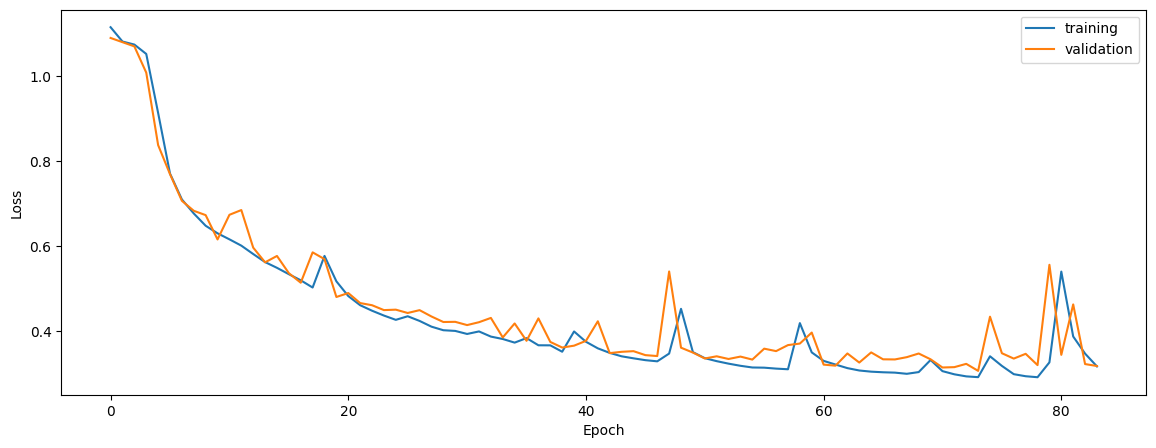

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.887353574908827


0.8815369371353077


0.8699006185280422


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.9037572322868254


0.8931587550228155


0.8832291834805267


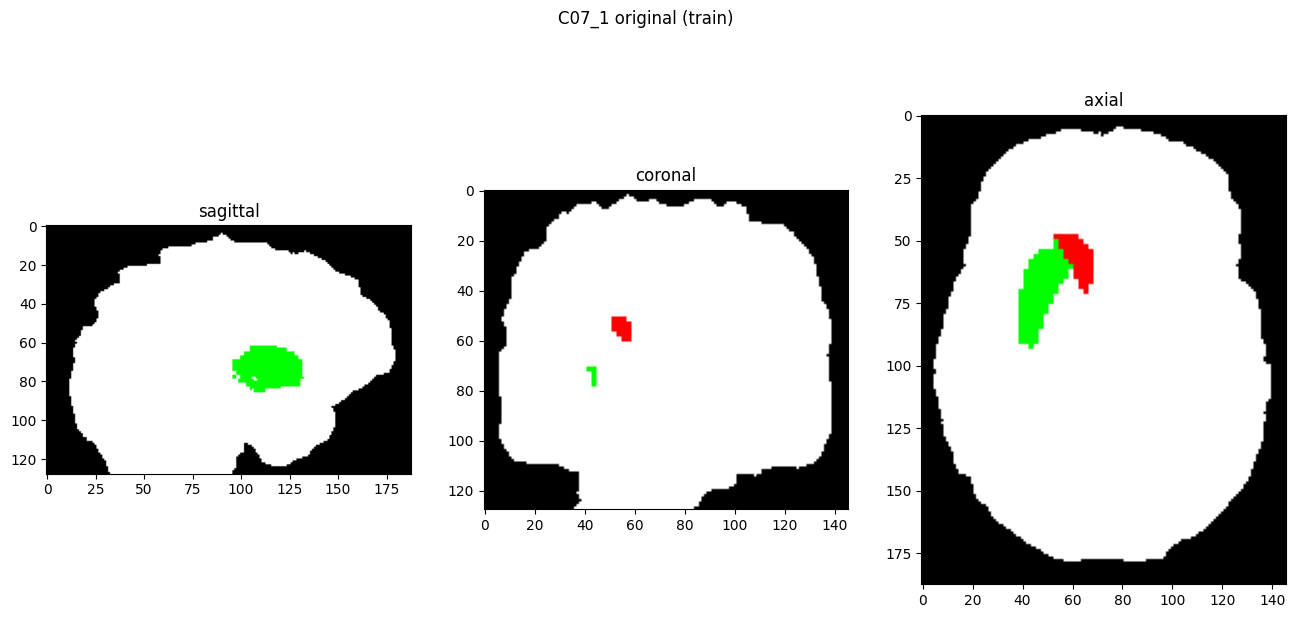

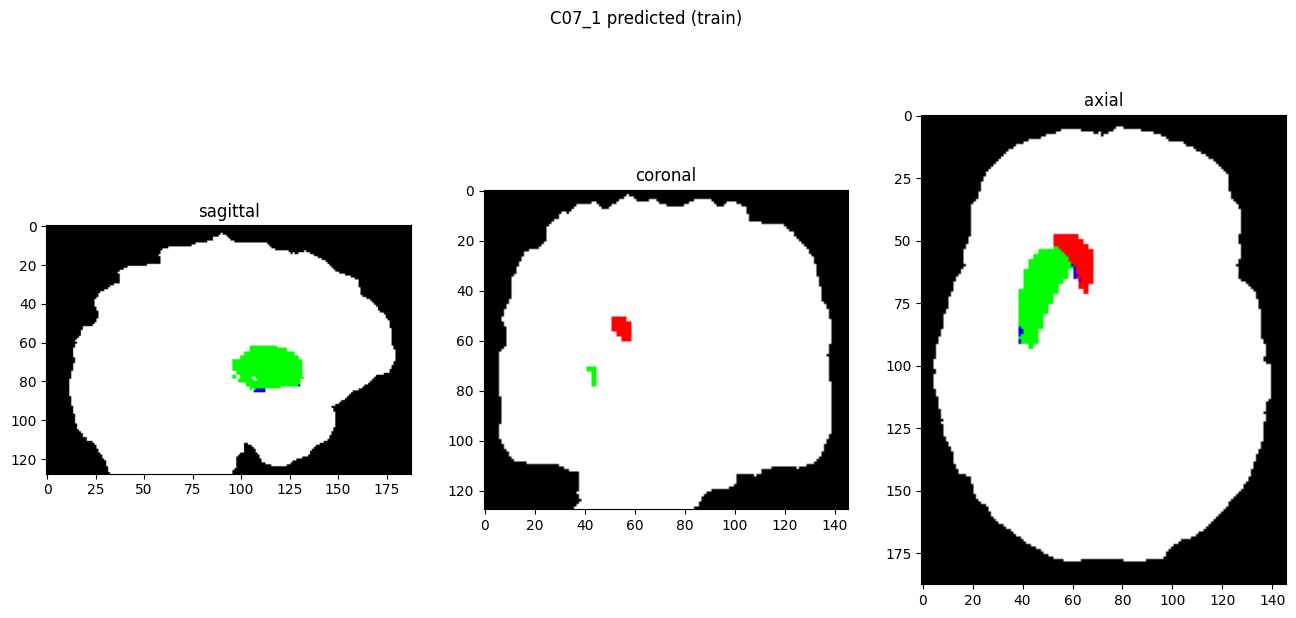

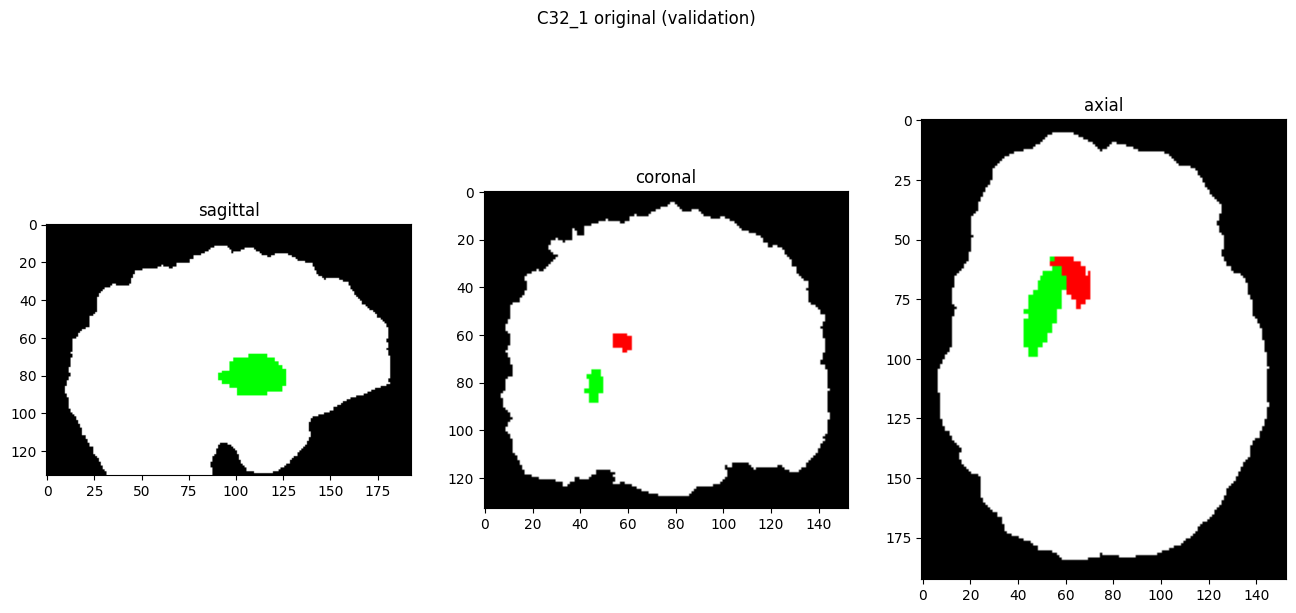

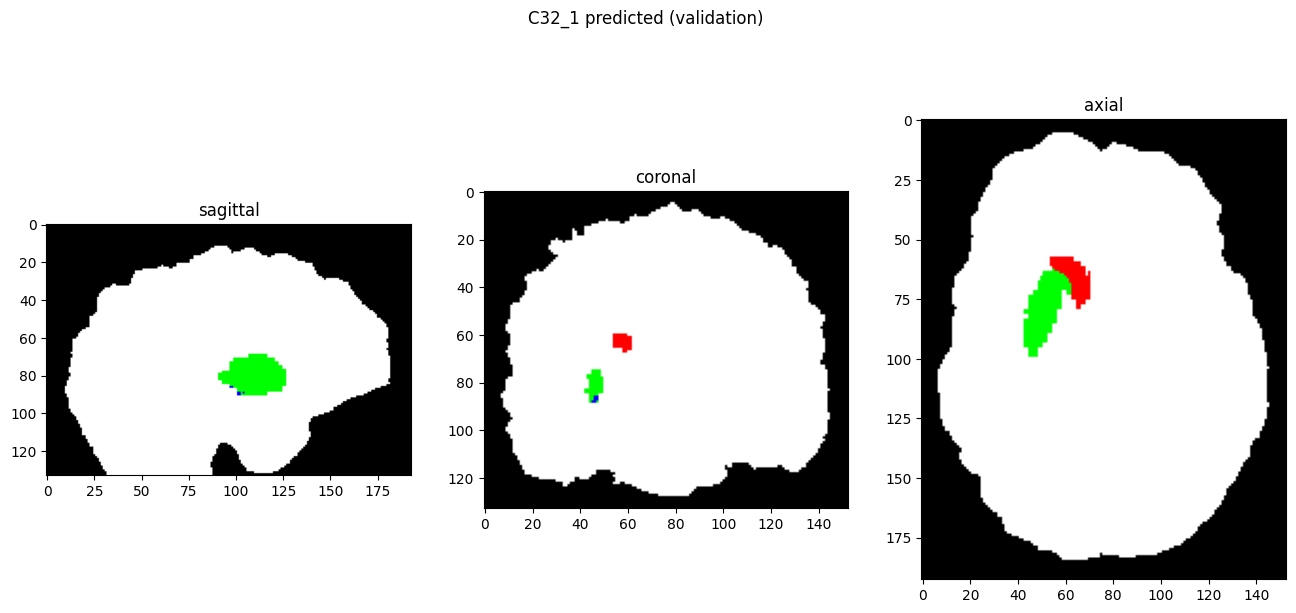

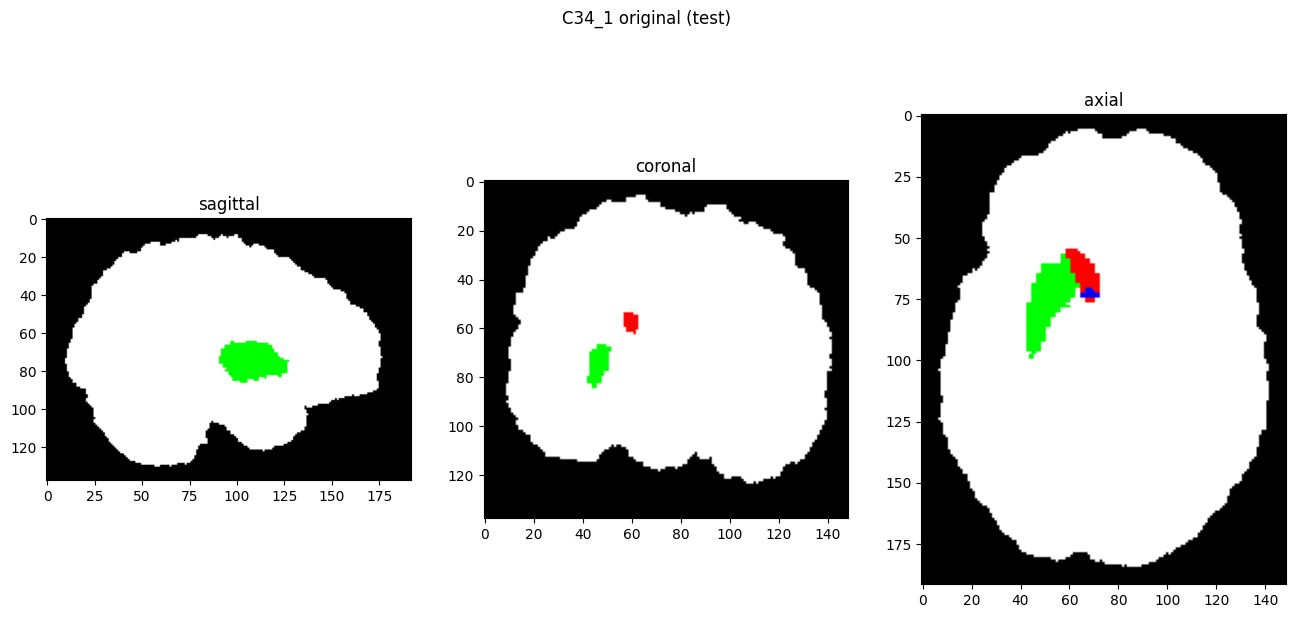

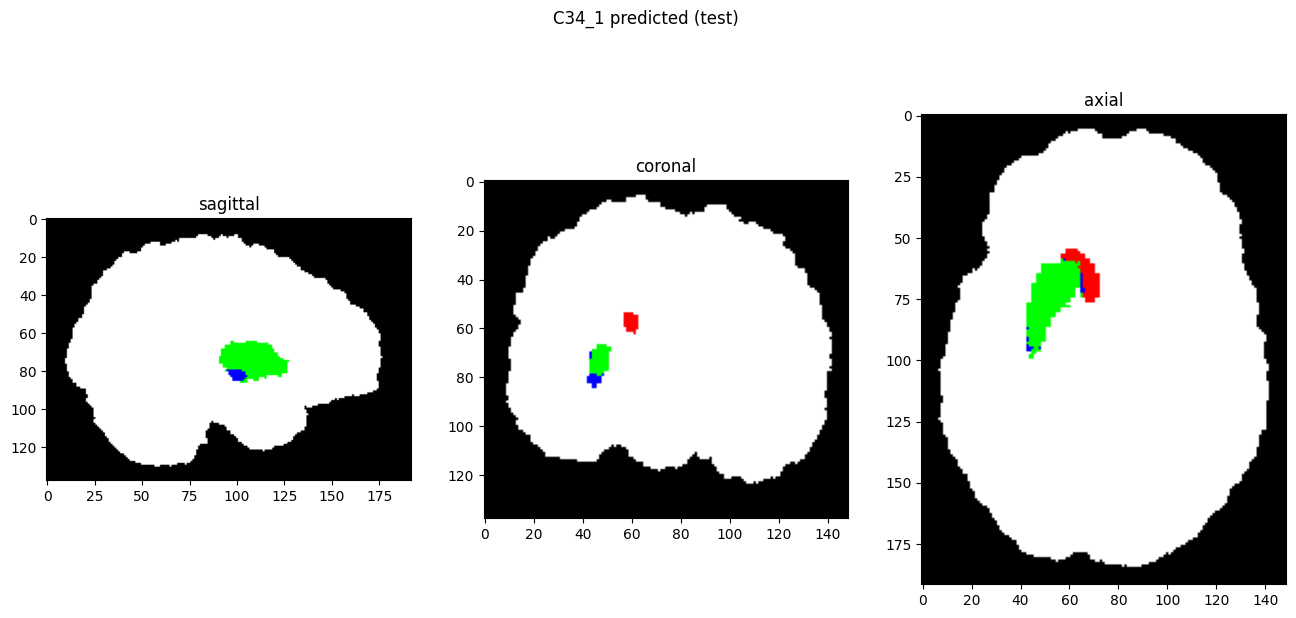

In [9]:
showResults(model, gen, threshold=0)